# Exeriment 2
Input data (from Step 0 [Case 2] in Experiment 1): 10 timesteps (averaged every 30 frames)
* Selected Eye gaze, Head pose, Au (EHA) Features: 23 dimensions
* All EHA features: 329 dimensions

Train, compile, and evaluation (No PCA)

In [1]:
import numpy as np
import pandas as pd
import pickle
from datetime import datetime
# from tensorflow import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
# from keras.layers import Attention
from tensorflow.keras.optimizers import *
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from livelossplot.tf_keras import PlotLossesCallback
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.utils import to_categorical

from sklearn.preprocessing import MinMaxScaler,LabelEncoder
from sklearn.metrics import mean_squared_error, confusion_matrix, accuracy_score, recall_score, precision_score, f1_score, fbeta_score, auc, roc_auc_score
from sklearn.model_selection import KFold

import seaborn as sns


%matplotlib inline
# %matplotlib notebook

# 1. Load dataset and data preparation

In [11]:
# Selected features: 
with open('daisee_openface/daisee_EHA.pkl','rb') as f:
    X_train_eye, X_val_eye, X_test_eye, X_train_head, X_val_head, X_test_head, X_train_au, X_val_au, X_test_au, Y_train_eye, Y_val_eye,  Y_test_eye= pickle.load(f)

# No feature selection:
with open('daisee_openface/daisee_329dims_10timesteps.pkl','rb') as f:
    X_train_all, X_val_all, X_test_all, X_train_all_scalled, X_val_all_scalled, X_test_all_scalled, Y_train, Y_val, Y_test = pickle.load(f)

#modify label
def modif_label(Y):
    Y = np.where(Y==1, 0, Y) #combine label 0 and 1
    Y = np.where(Y==2, 1, Y) #change label 2 to 1
    Y = np.where(Y==3, 2, Y) #change label 3 to 2
    print('Y before encode =', Y)
    # print('Shape before encode =', Y.shape)
    Y = LabelEncoder().fit_transform(Y) #encode label value as label variable
    print('Y after encode =', Y)
    print('Shape after encode =', Y.shape)
    # Y_cat = to_categorical(Y)
    return Y#, Y_cat

In [12]:
# stack all features
X_train = np.dstack((X_train_eye,X_train_head,X_train_au))
X_val = np.dstack((X_val_eye,X_val_head,X_val_au))
X_test = np.dstack ((X_test_eye,X_test_head,X_test_au))
print(X_train.shape,X_val.shape,X_test.shape)
print(X_train_all.shape, X_val_all.shape, X_test_all.shape)
print(X_train_all_scalled.shape, X_val_all_scalled.shape, X_test_all_scalled.shape)

(5467, 10, 23) (1703, 10, 23) (1782, 10, 23)
(5467, 10, 329) (1703, 10, 329) (1782, 10, 329)
(5467, 10, 329) (1703, 10, 329) (1782, 10, 329)


In [13]:
# Scalling for selected features input
tic = datetime.now()

scaler = MinMaxScaler(feature_range=(0,1))
X_train_scalled = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)

X_val_scalled = scaler.transform(X_val.reshape(-1, X_val.shape[-1])).reshape(X_val.shape)

X_test_scalled = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

time = datetime.now() - tic
print('Processing time {}'.format(time))
print(X_train_scalled.shape,X_val_scalled.shape,X_test_scalled.shape)

Processing time 0:00:00.015001
(5467, 10, 23) (1703, 10, 23) (1782, 10, 23)


In [15]:
Y_train = Y_train_eye
Y_train_modif = modif_label(Y_train)
Y_val = Y_val_eye
Y_val_modif = modif_label(Y_val)
Y_test = Y_test_eye
Y_test_modif = modif_label(Y_test)
print('Y train',Y_train_modif)

Y before encode = [1 1 2 ... 0 2 2]
Y after encode = [1 1 2 ... 0 2 2]
Shape after encode = (5467,)
Y before encode = [1 2 1 ... 1 2 1]
Y after encode = [1 2 1 ... 1 2 1]
Shape after encode = (1703,)
Y before encode = [1 1 1 ... 2 2 1]
Y after encode = [1 1 1 ... 2 2 1]
Shape after encode = (1782,)
Y train [1 1 2 ... 0 2 2]


In [16]:
Y_train_cat = to_categorical(Y_train_modif)
Y_val_cat = to_categorical(Y_val_modif)
Y_test_cat = to_categorical(Y_test_modif)
print('Y train',Y_train_cat.shape)

Y train (5467, 3)


# 2. Model

In [17]:
def vanilaLSTM(X):
    model = Sequential()
    model.add(LSTM(100, input_shape=(X.shape[1],X.shape[2])))
    model.add(Dropout(0.2))
    model.add(Dense(3, activation='softmax'))
    model._name='vanilaLSTM'
    print(model.summary())
    return model

def stackedLSTM(X):
    model = Sequential()
    model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(X.shape[1],X.shape[2])))
    model.add(LSTM(75, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    model._name='stackedLSTM'
    print(model.summary())
    return model

def biLSTM(X):
    model = Sequential()
    model.add(Bidirectional(LSTM(100, activation='relu'), input_shape=(X.shape[1],X.shape[2])))
    model.add(Dense(3, activation='softmax'))
    model._name='biLSTM'
    print(model.summary())
    return model

def biLSTM_en(X):
    model = Sequential()
    model.add(InputLayer(input_shape=((X.shape[1],X.shape[2]))))
    model.add(Dense(16))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(50)))
    model.add(Dropout(0.2))
    # modelD.add(GlobalAveragePooling1D())
    model.add(Dense(16))
    model.add(Activation('relu'))
    model.add(Dense(3, activation='softmax'))
    model._name='biLSTM_en'
    print(model.summary())
    return model

In [18]:
# Instantiate the model
vanilaLSTM_model = vanilaLSTM(X_train) # Selected feature input
vanilaLSTM_model_all = vanilaLSTM(X_train_all_scalled) # No feaure selection
vanilaLSTM_model_feat = vanilaLSTM(X_train_eye) #single feature input
vanilaLSTM_model_au = vanilaLSTM(X_train_au) #single feature input

stackedLSTM_model = stackedLSTM(X_train)
stackedLSTM_model_all = stackedLSTM(X_train_all_scalled)
stackedLSTM_model_feat = stackedLSTM(X_train_eye)
stackedLSTM_model_au = stackedLSTM(X_train_au)

biLSTM_model = biLSTM(X_train)
biLSTM_model_all = biLSTM(X_train_all_scalled)
biLSTM_model_feat = biLSTM(X_train_eye)
biLSTM_model_au = biLSTM(X_train_au)

biLSTM_en_model = biLSTM_en(X_train)
biLSTM_en_model_all = biLSTM_en(X_train_all_scalled)
biLSTM_en_model_feat = biLSTM_en(X_train_eye)
biLSTM_en_model_au = biLSTM_en(X_train_au)

Model: "vanilaLSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               49600     
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 3)                 303       
Total params: 49,903
Trainable params: 49,903
Non-trainable params: 0
_________________________________________________________________
None
Model: "vanilaLSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100)               172000    
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
___________________________

### Compile, fit, and evaluate the model

In [22]:
def compile_train(model,Xtrain,Ytrain,Xval,Yval):
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-3), metrics=['categorical_accuracy',tf.keras.metrics.AUC()]) #

    filepath = 'weights/' + model.name + '.hdf5'
    checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=2,
                                 save_weights_only=True, save_best_only=True,
                                 mode='auto')
    
    reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=2, min_lr=0.00001,mode='auto')

    es = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=20)
    history = model.fit(Xtrain,Ytrain, epochs=500, verbose=1,
                        callbacks = [PlotLossesCallback(), checkpoint, es],
                        batch_size = 32,
                        # validation_split=0.2,
                        validation_data = (Xval,Yval), 
                        shuffle=False,
                        class_weight = 'balanced'
                       ) 
    return history


def evaluate_error(trainedmodel,Xtest,Ytest): # X_test, Y_test,
    pred = trainedmodel.predict(Xtest, batch_size=32)
    pred = np.argmax(pred, axis=1)
    error = np.sum(np.not_equal(pred, Ytest)) / Ytest.shape[0] #error rate
    mse = mean_squared_error(Ytest,pred)
    acc = accuracy_score(Ytest, pred) #accuracy
    f1 = f1_score(Ytest, pred, average='macro')
    fbeta = fbeta_score(Ytest, pred, average='macro', beta=4)
    auc = roc_auc_score(Ytest, trainedmodel.predict_proba(Xtest), average='macro', multi_class='ovr')
    rc = recall_score(Ytest, pred, average=None) #Recall score
    ps = precision_score(Ytest, pred, average=None) #Precision
    print('|'+ trainedmodel.name + '|\n Error rate =', error,
        '\n MSE = ',mse,
        '\n Accuracy = ',acc,
        '\n AUC = ', auc,
        '\n F1-score = ',f1,
        '\n Fbeta = ',fbeta
        )

    #  Plotting confusion matrix
    cm = confusion_matrix(Ytest, pred) #confusion matrix
    cm = pd.DataFrame(cm,range(3),range(3))

    plt.figure(figsize=(6,6))
    sns.set(font_scale=1.5)
    sns.heatmap(cm, annot=True, annot_kws={"size":16}, fmt='g', cmap='Blues', cbar=False)
    plt.xlabel("Predicted Values")
    plt.ylabel("Actual Values")
    return 

### Train and compile


## 1. Vanila LSTM

No feature selection  (329 dimensions)

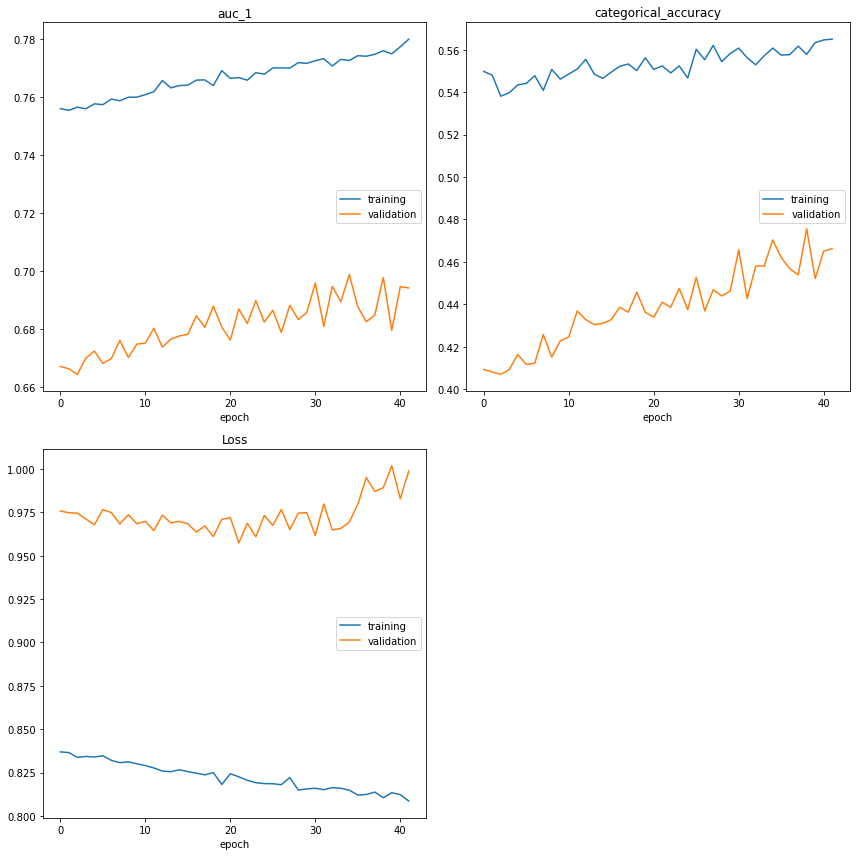

auc_1
	training         	 (min:    0.755, max:    0.780, cur:    0.780)
	validation       	 (min:    0.664, max:    0.699, cur:    0.694)
categorical_accuracy
	training         	 (min:    0.538, max:    0.565, cur:    0.565)
	validation       	 (min:    0.407, max:    0.476, cur:    0.466)
Loss
	training         	 (min:    0.809, max:    0.837, cur:    0.809)
	validation       	 (min:    0.957, max:    1.002, cur:    0.999)
5467/5467 [==============================] - 1s 184us/sample - loss: 0.8086 - categorical_accuracy: 0.5650 - auc_1: 0.7799 - val_loss: 0.9990 - val_categorical_accuracy: 0.4662 - val_auc_1: 0.6942
Training time:0:00:44.688965
1782/1782 [==============================] - 0s 71us/sample - loss: 0.8706 - categorical_accuracy: 0.4781 - auc_1: 0.7261
Accuracy on Test set: 47.81%
|vanilaLSTM|
 Error rate = 0.5218855218855218 
 MSE =  0.5959595959595959 
 Accuracy =  0.4781144781144781 
 AUC =  0.5609171839202053 
 F1-score =  0.3186929239790246 
 Fbeta =  0.33600992630113

c:\Users\hasegawa-lab-pc\miniconda3\envs\tf2.1\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


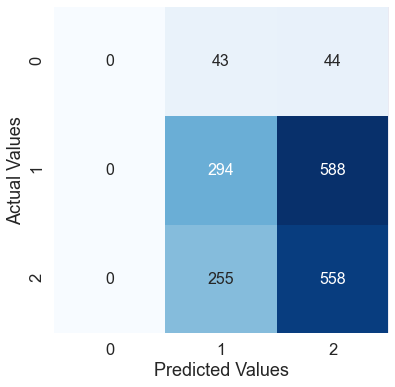

In [23]:
tic = datetime.now()

compile_train(vanilaLSTM_model_all,X_train_all_scalled,Y_train_cat,X_val_all_scalled,Y_val_cat) 
time = datetime.now() - tic
print("Training time:{}".format(time))

scores = vanilaLSTM_model_all.evaluate(X_test_all_scalled,Y_test_cat)
print("Accuracy on Test set: %.2f%%" % (scores[1]*100))

print(evaluate_error(vanilaLSTM_model_all,X_test_all_scalled, Y_test_modif))


Selected features (non-scalled)

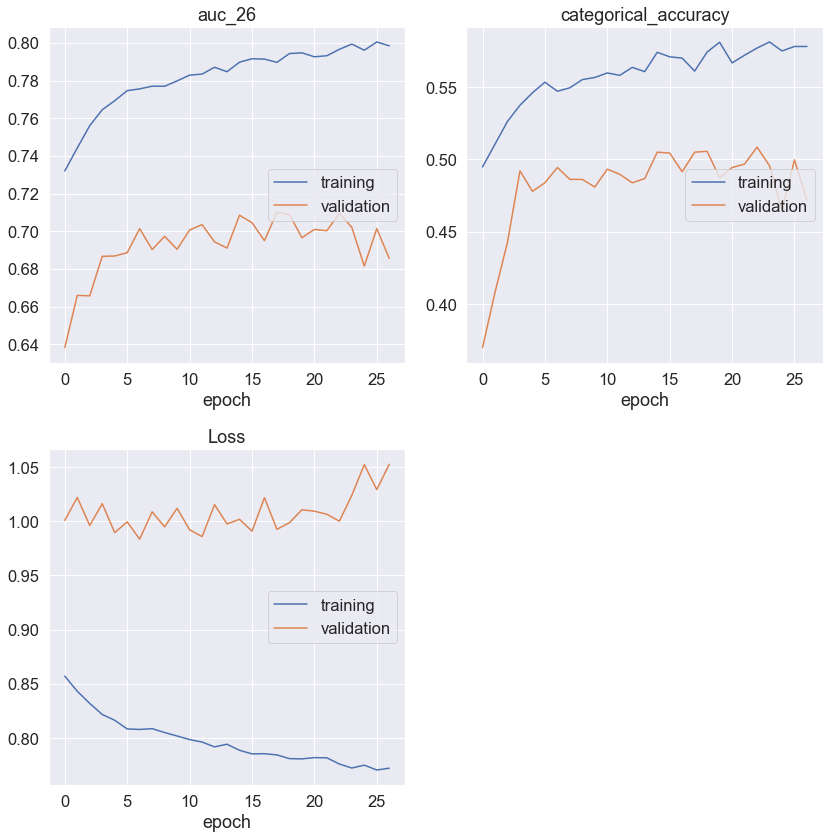

auc_26
	training         	 (min:    0.732, max:    0.800, cur:    0.798)
	validation       	 (min:    0.638, max:    0.710, cur:    0.686)
categorical_accuracy
	training         	 (min:    0.495, max:    0.581, cur:    0.578)
	validation       	 (min:    0.370, max:    0.509, cur:    0.472)
Loss
	training         	 (min:    0.770, max:    0.857, cur:    0.772)
	validation       	 (min:    0.983, max:    1.053, cur:    1.053)
5467/5467 [==============================] - 1s 204us/sample - loss: 0.7722 - categorical_accuracy: 0.5780 - auc_26: 0.7984 - val_loss: 1.0526 - val_categorical_accuracy: 0.4715 - val_auc_26: 0.6856
Training time:0:00:30.374999
1782/1782 [==============================] - 0s 67us/sample - loss: 0.8889 - categorical_accuracy: 0.4837 - auc_26: 0.7193
Accuracy on Test set: 48.37%
|vanilaLSTM|
 Error rate = 0.5162738496071829 
 MSE =  0.6139169472502806 
 Accuracy =  0.4837261503928171 
 AUC =  0.534863805439245 
 F1-score =  0.32900087981449727 
 Fbeta =  0.3395272021

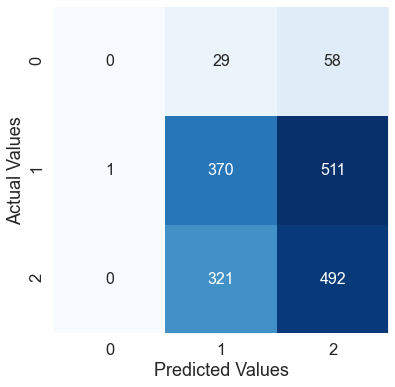

In [48]:
tic = datetime.now()

compile_train(vanilaLSTM_model,X_train,Y_train_cat,X_val,Y_val_cat) 
time = datetime.now() - tic
print("Training time:{}".format(time))

scores = vanilaLSTM_model.evaluate(X_test,Y_test_cat)
print("Accuracy on Test set: %.2f%%" % (scores[1]*100))

print(evaluate_error(vanilaLSTM_model,X_test, Y_test_modif))


Selected features (scalled)

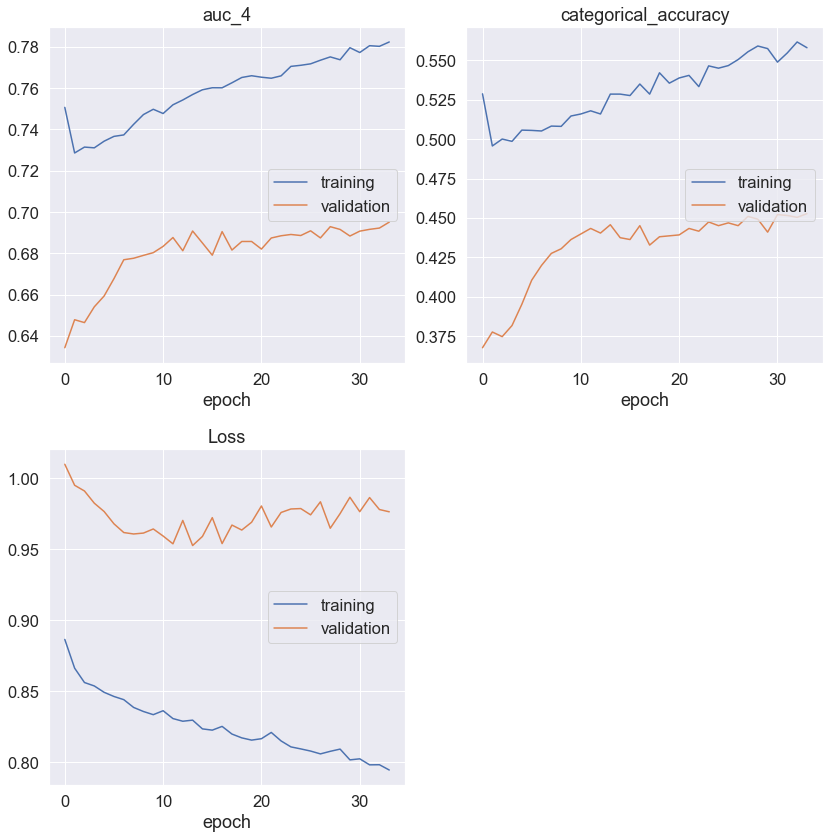

auc_4
	training         	 (min:    0.729, max:    0.782, cur:    0.782)
	validation       	 (min:    0.634, max:    0.695, cur:    0.695)
categorical_accuracy
	training         	 (min:    0.496, max:    0.562, cur:    0.558)
	validation       	 (min:    0.368, max:    0.453, cur:    0.453)
Loss
	training         	 (min:    0.795, max:    0.887, cur:    0.795)
	validation       	 (min:    0.953, max:    1.010, cur:    0.976)
5467/5467 [==============================] - 1s 214us/sample - loss: 0.7945 - categorical_accuracy: 0.5581 - auc_4: 0.7824 - val_loss: 0.9764 - val_categorical_accuracy: 0.4527 - val_auc_4: 0.6951
Training time:0:00:37.821753
1782/1782 [==============================] - 0s 75us/sample - loss: 0.8728 - categorical_accuracy: 0.4675 - auc_4: 0.7154
Accuracy on Test set: 46.75%
|vanilaLSTM|
 Error rate = 0.5325476992143658 
 MSE =  0.6066217732884399 
 Accuracy =  0.4674523007856341 
 AUC =  0.5433823683155586 
 F1-score =  0.3412764961506176 
 Fbeta =  0.34325512088245

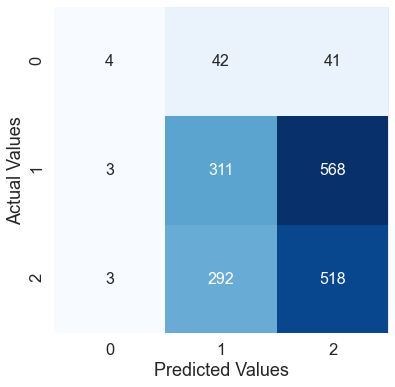

In [26]:
tic = datetime.now()

compile_train(vanilaLSTM_model,X_train_scalled,Y_train_cat,X_val_scalled,Y_val_cat) 
time = datetime.now() - tic
print("Training time:{}".format(time))

scores = vanilaLSTM_model.evaluate(X_test_scalled,Y_test_cat)
print("Accuracy on Test set: %.2f%%" % (scores[1]*100))
print(evaluate_error(vanilaLSTM_model,X_test_scalled,Y_test_modif))

Eye Gaze only

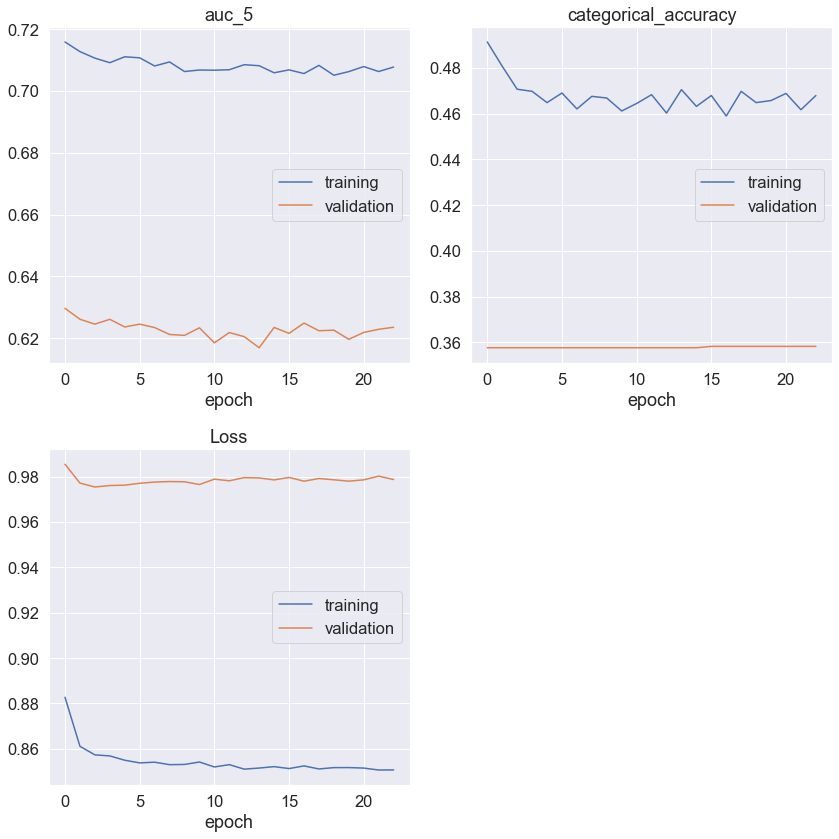

auc_5
	training         	 (min:    0.705, max:    0.716, cur:    0.708)
	validation       	 (min:    0.617, max:    0.630, cur:    0.624)
categorical_accuracy
	training         	 (min:    0.459, max:    0.491, cur:    0.468)
	validation       	 (min:    0.358, max:    0.358, cur:    0.358)
Loss
	training         	 (min:    0.851, max:    0.883, cur:    0.851)
	validation       	 (min:    0.975, max:    0.985, cur:    0.979)
5467/5467 [==============================] - 1s 195us/sample - loss: 0.8507 - categorical_accuracy: 0.4679 - auc_5: 0.7077 - val_loss: 0.9787 - val_categorical_accuracy: 0.3582 - val_auc_5: 0.6236
Training time:0:00:26.175789
1782/1782 [==============================] - 0s 74us/sample - loss: 0.8587 - categorical_accuracy: 0.4562 - auc_5: 0.7040
Accuracy on Test set: 45.62%
|vanilaLSTM|
 Error rate = 0.5437710437710438 
 MSE =  0.6902356902356902 
 Accuracy =  0.4562289562289562 
 AUC =  0.4928004132255879 
 F1-score =  0.20886319845857415 
 Fbeta =  0.3114942528735

c:\Users\hasegawa-lab-pc\miniconda3\envs\tf2.1\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


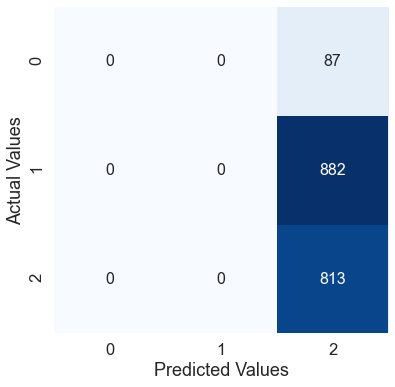

In [27]:
tic = datetime.now()

compile_train(vanilaLSTM_model_feat,X_train_eye,Y_train_cat,X_val_eye,Y_val_cat) 
time = datetime.now() - tic
print("Training time:{}".format(time))

scores = vanilaLSTM_model_feat.evaluate(X_test_eye,Y_test_cat)
print("Accuracy on Test set: %.2f%%" % (scores[1]*100))
print(evaluate_error(vanilaLSTM_model_feat,X_test_eye,Y_test_modif))

Head Pose only

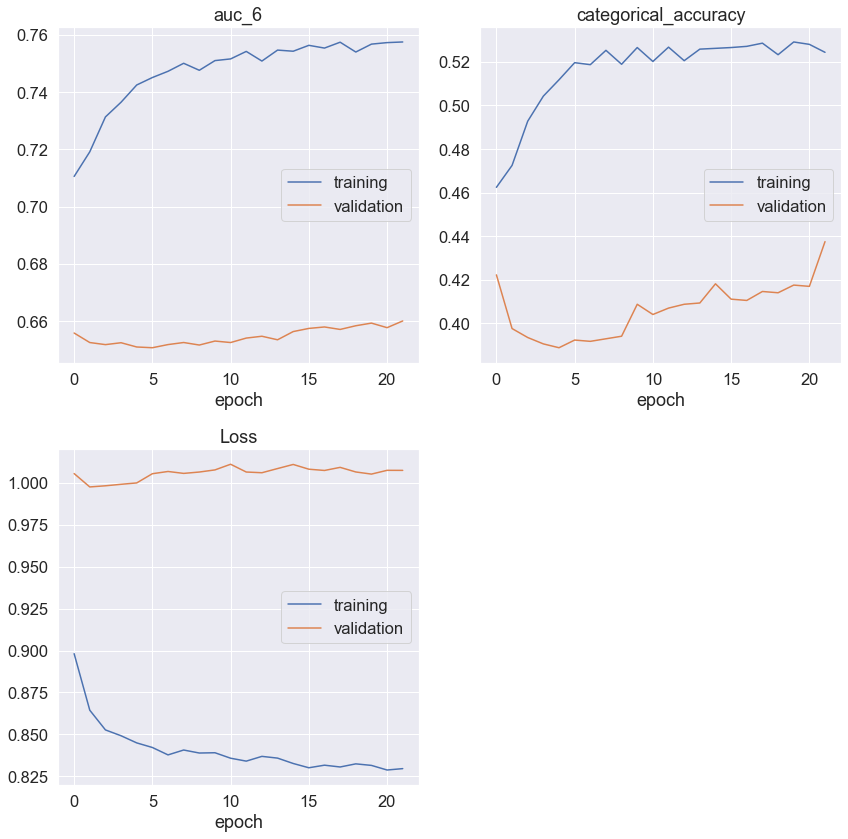

auc_6
	training         	 (min:    0.711, max:    0.757, cur:    0.757)
	validation       	 (min:    0.651, max:    0.660, cur:    0.660)
categorical_accuracy
	training         	 (min:    0.462, max:    0.529, cur:    0.524)
	validation       	 (min:    0.389, max:    0.437, cur:    0.437)
Loss
	training         	 (min:    0.829, max:    0.898, cur:    0.830)
	validation       	 (min:    0.998, max:    1.011, cur:    1.007)
5467/5467 [==============================] - 1s 196us/sample - loss: 0.8296 - categorical_accuracy: 0.5244 - auc_6: 0.7575 - val_loss: 1.0074 - val_categorical_accuracy: 0.4375 - val_auc_6: 0.6600
Training time:0:00:25.089999
1782/1782 [==============================] - 0s 69us/sample - loss: 0.8735 - categorical_accuracy: 0.4691 - auc_6: 0.7079
Accuracy on Test set: 46.91%
|vanilaLSTM|
 Error rate = 0.5308641975308642 
 MSE =  0.6268237934904601 
 Accuracy =  0.4691358024691358 
 AUC =  0.48543608950206724 
 F1-score =  0.3172363104260143 
 Fbeta =  0.3295372192966

c:\Users\hasegawa-lab-pc\miniconda3\envs\tf2.1\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


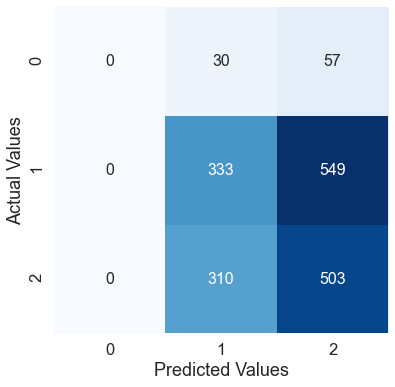

In [28]:
tic = datetime.now()

compile_train(vanilaLSTM_model_feat,X_train_head,Y_train_cat,X_val_head,Y_val_cat) 
time = datetime.now() - tic
print("Training time:{}".format(time))

scores = vanilaLSTM_model_feat.evaluate(X_test_head,Y_test_cat)
print("Accuracy on Test set: %.2f%%" % (scores[1]*100))
print(evaluate_error(vanilaLSTM_model_feat,X_test_head,Y_test_modif))

AU only

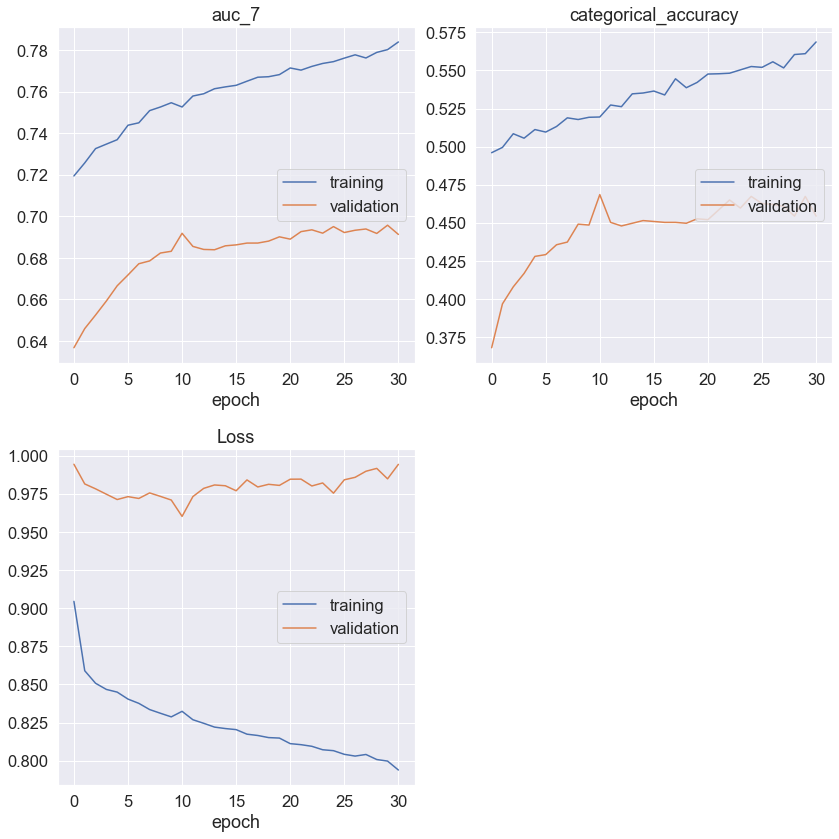

auc_7
	training         	 (min:    0.720, max:    0.784, cur:    0.784)
	validation       	 (min:    0.637, max:    0.696, cur:    0.691)
categorical_accuracy
	training         	 (min:    0.496, max:    0.569, cur:    0.569)
	validation       	 (min:    0.368, max:    0.469, cur:    0.454)
Loss
	training         	 (min:    0.794, max:    0.904, cur:    0.794)
	validation       	 (min:    0.960, max:    0.994, cur:    0.994)
5467/5467 [==============================] - 1s 198us/sample - loss: 0.7938 - categorical_accuracy: 0.5687 - auc_7: 0.7841 - val_loss: 0.9944 - val_categorical_accuracy: 0.4545 - val_auc_7: 0.6914
Training time:0:00:34.595935
1782/1782 [==============================] - 0s 65us/sample - loss: 0.8804 - categorical_accuracy: 0.4652 - auc_7: 0.7155
Accuracy on Test set: 46.52%
|vanilaLSTM|
 Error rate = 0.5347923681257014 
 MSE =  0.6206509539842873 
 Accuracy =  0.46520763187429853 
 AUC =  0.5454758256782526 
 F1-score =  0.3143863758710214 
 Fbeta =  0.3306464778549

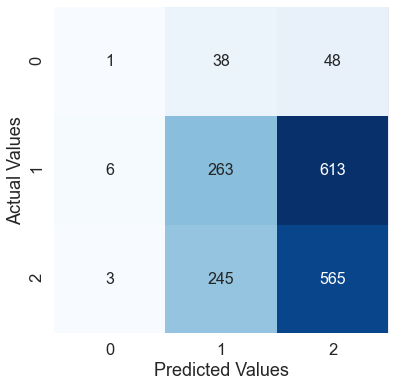

In [29]:
tic = datetime.now()

compile_train(vanilaLSTM_model_au,X_train_au,Y_train_cat,X_val_au,Y_val_cat) 
time = datetime.now() - tic
print("Training time:{}".format(time))

scores = vanilaLSTM_model_au.evaluate(X_test_au,Y_test_cat)
print("Accuracy on Test set: %.2f%%" % (scores[1]*100))
print(evaluate_error(vanilaLSTM_model_au,X_test_au,Y_test_modif))

## 2. Stacked LSTM

No feature selection  (329 dimensions)

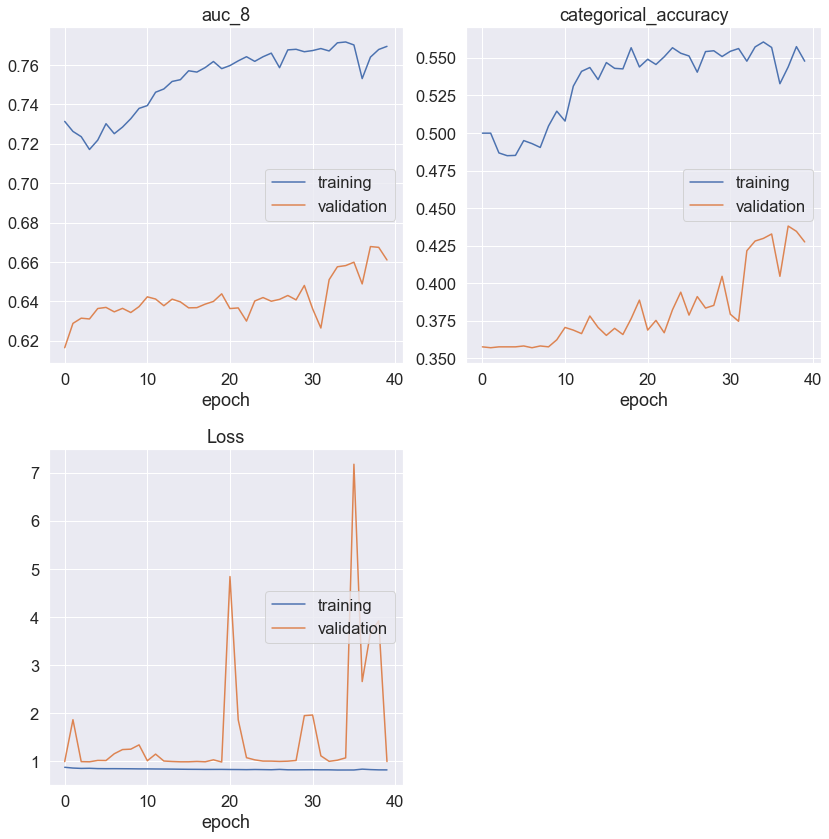

auc_8
	training         	 (min:    0.717, max:    0.772, cur:    0.769)
	validation       	 (min:    0.616, max:    0.668, cur:    0.661)
categorical_accuracy
	training         	 (min:    0.485, max:    0.561, cur:    0.548)
	validation       	 (min:    0.357, max:    0.438, cur:    0.427)
Loss
	training         	 (min:    0.822, max:    0.879, cur:    0.825)
	validation       	 (min:    0.989, max:    7.177, cur:    0.998)
5467/5467 [==============================] - 3s 613us/sample - loss: 0.8248 - categorical_accuracy: 0.5478 - auc_8: 0.7695 - val_loss: 0.9979 - val_categorical_accuracy: 0.4275 - val_auc_8: 0.6610
Training time:0:02:16.373397
1782/1782 [==============================] - 0s 162us/sample - loss: 0.8713 - categorical_accuracy: 0.4776 - auc_8: 0.7144
Accuracy on Test set: 47.76%
|stackedLSTM|
 Error rate = 0.5224466891133558 
 MSE =  0.6301907968574635 
 Accuracy =  0.4775533108866442 
 AUC =  0.5318521410197868 
 F1-score =  0.2932282318238173 
 Fbeta =  0.333459481466

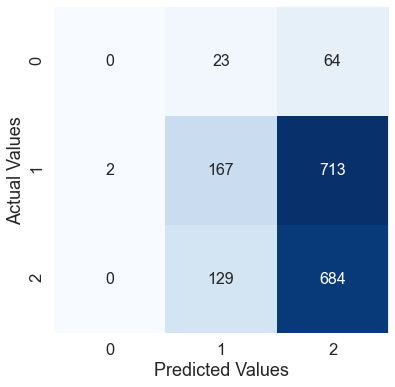

In [30]:
tic = datetime.now()

compile_train(stackedLSTM_model_all,X_train_all_scalled,Y_train_cat,X_val_all_scalled,Y_val_cat) 
time = datetime.now() - tic
print("Training time:{}".format(time))

scores = stackedLSTM_model_all.evaluate(X_test_all_scalled,Y_test_cat)
print("Accuracy on Test set: %.2f%%" % (scores[1]*100))

print(evaluate_error(stackedLSTM_model_all,X_test_all_scalled, Y_test_modif))

Selected features (non-scalled)

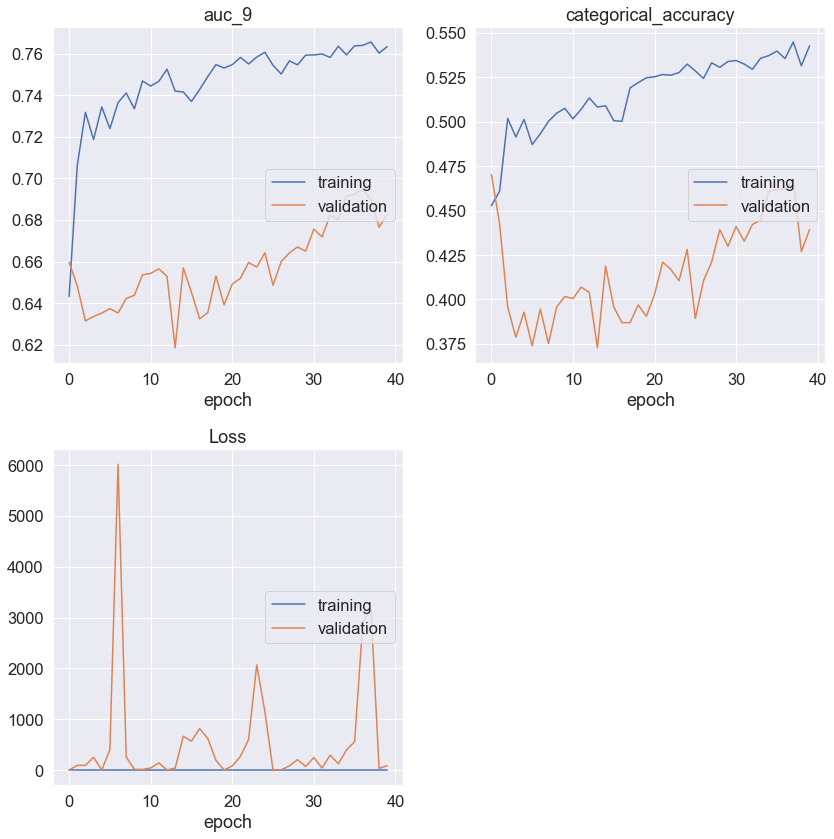

auc_9
	training         	 (min:    0.643, max:    0.766, cur:    0.763)
	validation       	 (min:    0.619, max:    0.695, cur:    0.683)
categorical_accuracy
	training         	 (min:    0.453, max:    0.545, cur:    0.543)
	validation       	 (min:    0.373, max:    0.470, cur:    0.439)
Loss
	training         	 (min:    0.817, max:    4.000, cur:    0.819)
	validation       	 (min:    0.990, max: 6014.706, cur:   84.550)
5467/5467 [==============================] - 3s 580us/sample - loss: 0.8189 - categorical_accuracy: 0.5425 - auc_9: 0.7634 - val_loss: 84.5504 - val_categorical_accuracy: 0.4392 - val_auc_9: 0.6827
Training time:0:02:18.997742
1782/1782 [==============================] - 0s 158us/sample - loss: 0.9827 - categorical_accuracy: 0.4865 - auc_9: 0.7102
Accuracy on Test set: 48.65%
|stackedLSTM|
 Error rate = 0.5134680134680135 
 MSE =  0.6094276094276094 
 Accuracy =  0.48653198653198654 
 AUC =  0.4890329154071817 
 F1-score =  0.3382212237769788 
 Fbeta =  0.3451979667

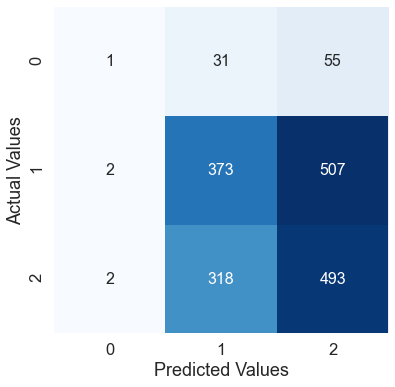

In [31]:
tic = datetime.now()

compile_train(stackedLSTM_model,X_train,Y_train_cat,X_val,Y_val_cat) 
time = datetime.now() - tic
print("Training time:{}".format(time))

scores = stackedLSTM_model.evaluate(X_test,Y_test_cat)
print("Accuracy on Test set: %.2f%%" % (scores[1]*100))

print(evaluate_error(stackedLSTM_model,X_test, Y_test_modif))

Selected features (scalled)

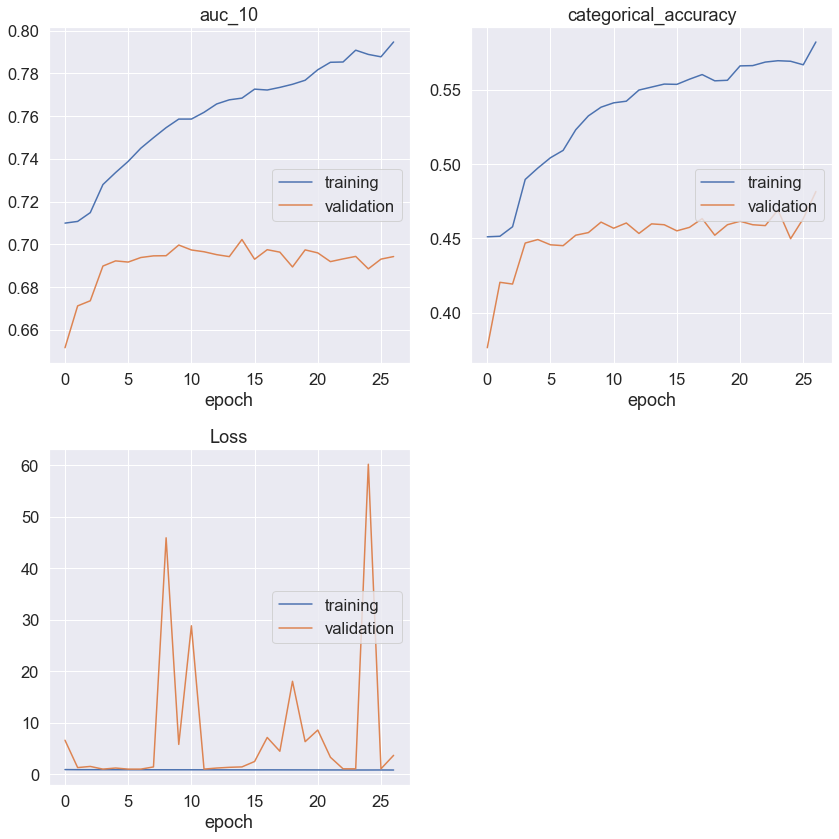

auc_10
	training         	 (min:    0.710, max:    0.795, cur:    0.795)
	validation       	 (min:    0.652, max:    0.702, cur:    0.694)
categorical_accuracy
	training         	 (min:    0.451, max:    0.582, cur:    0.582)
	validation       	 (min:    0.376, max:    0.482, cur:    0.482)
Loss
	training         	 (min:    0.781, max:    0.864, cur:    0.781)
	validation       	 (min:    0.954, max:   60.214, cur:    3.633)
5467/5467 [==============================] - 3s 597us/sample - loss: 0.7813 - categorical_accuracy: 0.5822 - auc_10: 0.7947 - val_loss: 3.6328 - val_categorical_accuracy: 0.4815 - val_auc_10: 0.6943
Training time:0:01:28.965486
1782/1782 [==============================] - 0s 162us/sample - loss: 0.9173 - categorical_accuracy: 0.4613 - auc_10: 0.7063
Accuracy on Test set: 46.13%
|stackedLSTM|
 Error rate = 0.5387205387205387 
 MSE =  0.6094276094276094 
 Accuracy =  0.4612794612794613 
 AUC =  0.515631841187303 
 F1-score =  0.356574864946015 
 Fbeta =  0.3489881551

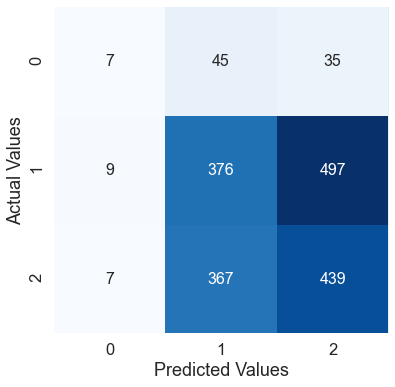

In [32]:
tic = datetime.now()

compile_train(stackedLSTM_model,X_train_scalled,Y_train_cat,X_val_scalled,Y_val_cat) 
time = datetime.now() - tic
print("Training time:{}".format(time))

scores = stackedLSTM_model.evaluate(X_test_scalled,Y_test_cat)
print("Accuracy on Test set: %.2f%%" % (scores[1]*100))
print(evaluate_error(stackedLSTM_model,X_test_scalled,Y_test_modif))

Eye Gaze only

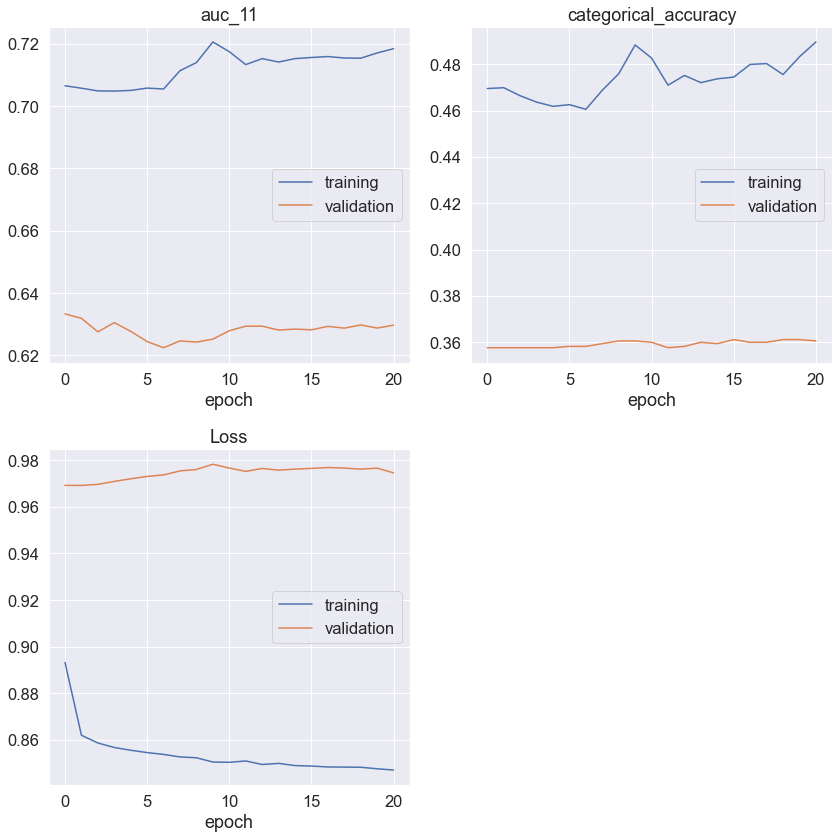

auc_11
	training         	 (min:    0.705, max:    0.721, cur:    0.718)
	validation       	 (min:    0.622, max:    0.633, cur:    0.630)
categorical_accuracy
	training         	 (min:    0.461, max:    0.490, cur:    0.490)
	validation       	 (min:    0.358, max:    0.361, cur:    0.361)
Loss
	training         	 (min:    0.847, max:    0.893, cur:    0.847)
	validation       	 (min:    0.969, max:    0.978, cur:    0.975)
5467/5467 [==============================] - 3s 593us/sample - loss: 0.8471 - categorical_accuracy: 0.4897 - auc_11: 0.7184 - val_loss: 0.9745 - val_categorical_accuracy: 0.3605 - val_auc_11: 0.6297
Training time:0:01:08.800065
1782/1782 [==============================] - 0s 154us/sample - loss: 0.8618 - categorical_accuracy: 0.4501 - auc_11: 0.7033
Accuracy on Test set: 45.01%
|stackedLSTM|
 Error rate = 0.5499438832772167 
 MSE =  0.6829405162738497 
 Accuracy =  0.4500561167227834 
 AUC =  0.5086133603162583 
 F1-score =  0.23675956785651034 
 Fbeta =  0.3104662

c:\Users\hasegawa-lab-pc\miniconda3\envs\tf2.1\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


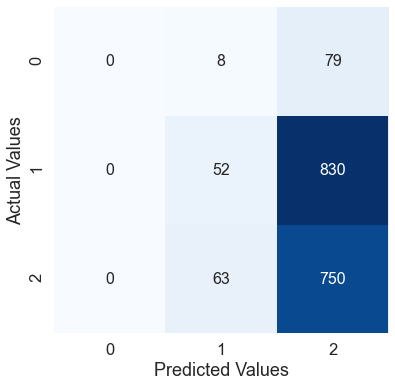

In [33]:
tic = datetime.now()

compile_train(stackedLSTM_model_feat,X_train_eye,Y_train_cat,X_val_eye,Y_val_cat) 
time = datetime.now() - tic
print("Training time:{}".format(time))

scores = stackedLSTM_model_feat.evaluate(X_test_eye,Y_test_cat)
print("Accuracy on Test set: %.2f%%" % (scores[1]*100))
print(evaluate_error(stackedLSTM_model_feat,X_test_eye,Y_test_modif))

Head Pose only

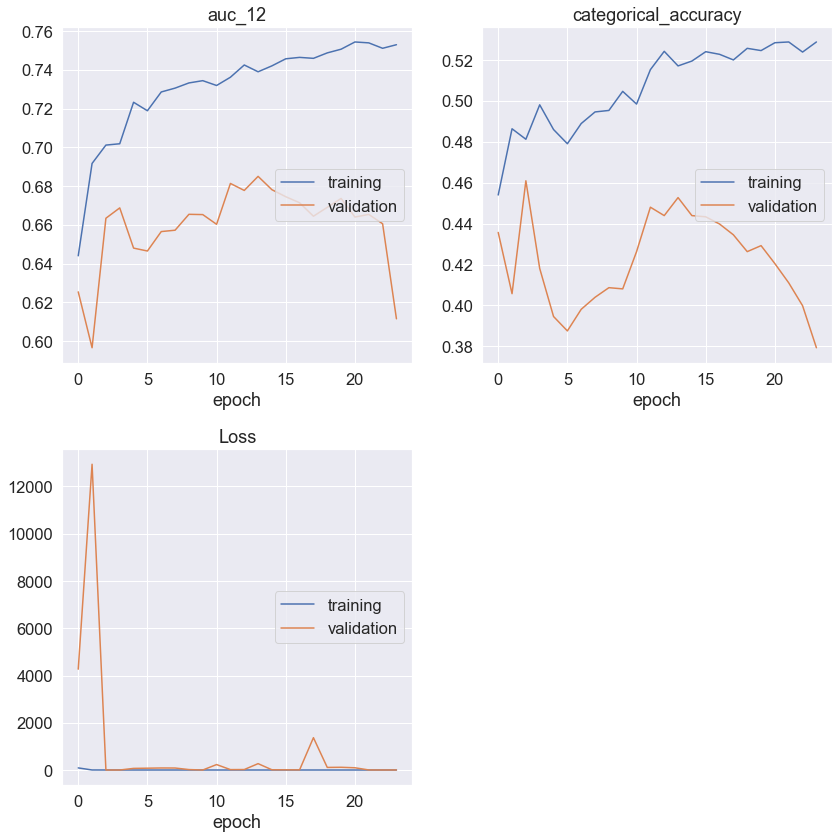

auc_12
	training         	 (min:    0.644, max:    0.754, cur:    0.753)
	validation       	 (min:    0.597, max:    0.685, cur:    0.611)
categorical_accuracy
	training         	 (min:    0.454, max:    0.529, cur:    0.529)
	validation       	 (min:    0.379, max:    0.461, cur:    0.379)
Loss
	training         	 (min:    0.832, max:   90.029, cur:    0.929)
	validation       	 (min:    1.023, max: 12941.118, cur:    2.687)
5467/5467 [==============================] - 3s 616us/sample - loss: 0.9295 - categorical_accuracy: 0.5288 - auc_12: 0.7531 - val_loss: 2.6870 - val_categorical_accuracy: 0.3793 - val_auc_12: 0.6115
Training time:0:01:18.104061
1782/1782 [==============================] - 0s 157us/sample - loss: 1.0211 - categorical_accuracy: 0.4675 - auc_12: 0.6968
Accuracy on Test set: 46.75%
|stackedLSTM|
 Error rate = 0.5325476992143658 
 MSE =  0.6638608305274972 
 Accuracy =  0.4674523007856341 
 AUC =  0.5111384915302817 
 F1-score =  0.3437847695913723 
 Fbeta =  0.3633432

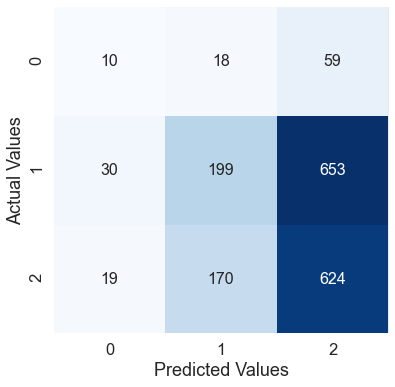

In [34]:
tic = datetime.now()

compile_train(stackedLSTM_model_feat,X_train_head,Y_train_cat,X_val_head,Y_val_cat) 
time = datetime.now() - tic
print("Training time:{}".format(time))

scores = stackedLSTM_model_feat.evaluate(X_test_head,Y_test_cat)
print("Accuracy on Test set: %.2f%%" % (scores[1]*100))
print(evaluate_error(stackedLSTM_model_feat,X_test_head,Y_test_modif))

AU only

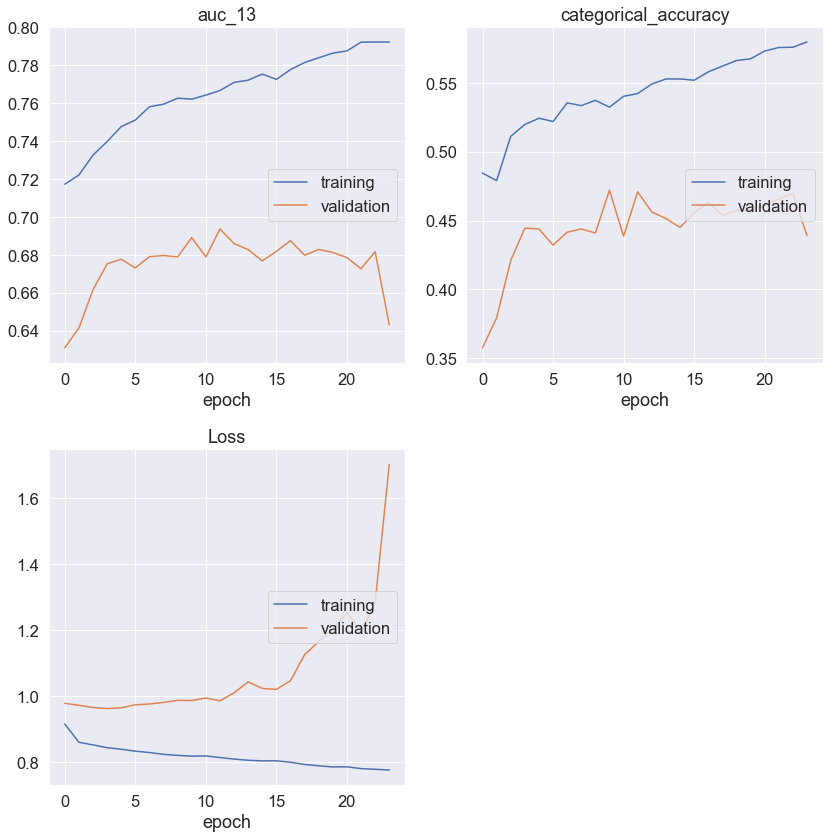

auc_13
	training         	 (min:    0.717, max:    0.792, cur:    0.792)
	validation       	 (min:    0.631, max:    0.694, cur:    0.643)
categorical_accuracy
	training         	 (min:    0.479, max:    0.580, cur:    0.580)
	validation       	 (min:    0.358, max:    0.472, cur:    0.439)
Loss
	training         	 (min:    0.777, max:    0.916, cur:    0.777)
	validation       	 (min:    0.963, max:    1.704, cur:    1.704)
5467/5467 [==============================] - 4s 682us/sample - loss: 0.7766 - categorical_accuracy: 0.5798 - auc_13: 0.7923 - val_loss: 1.7035 - val_categorical_accuracy: 0.4392 - val_auc_13: 0.6432
Training time:0:01:23.997999
1782/1782 [==============================] - 0s 159us/sample - loss: 1.0638 - categorical_accuracy: 0.4557 - auc_13: 0.7026
Accuracy on Test set: 45.57%
|stackedLSTM|
 Error rate = 0.5443322109988776 
 MSE =  0.6352413019079686 
 Accuracy =  0.4556677890011223 
 AUC =  0.5195057747852244 
 F1-score =  0.348949736335086 
 Fbeta =  0.349310519

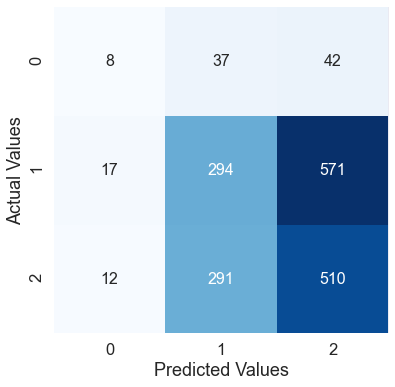

In [35]:
tic = datetime.now()

compile_train(stackedLSTM_model_au,X_train_au,Y_train_cat,X_val_au,Y_val_cat) 
time = datetime.now() - tic
print("Training time:{}".format(time))

scores = stackedLSTM_model_au.evaluate(X_test_au,Y_test_cat)
print("Accuracy on Test set: %.2f%%" % (scores[1]*100))
print(evaluate_error(stackedLSTM_model_au,X_test_au,Y_test_modif))

## 3. biLSTM

No feature selection (329 dimensions)

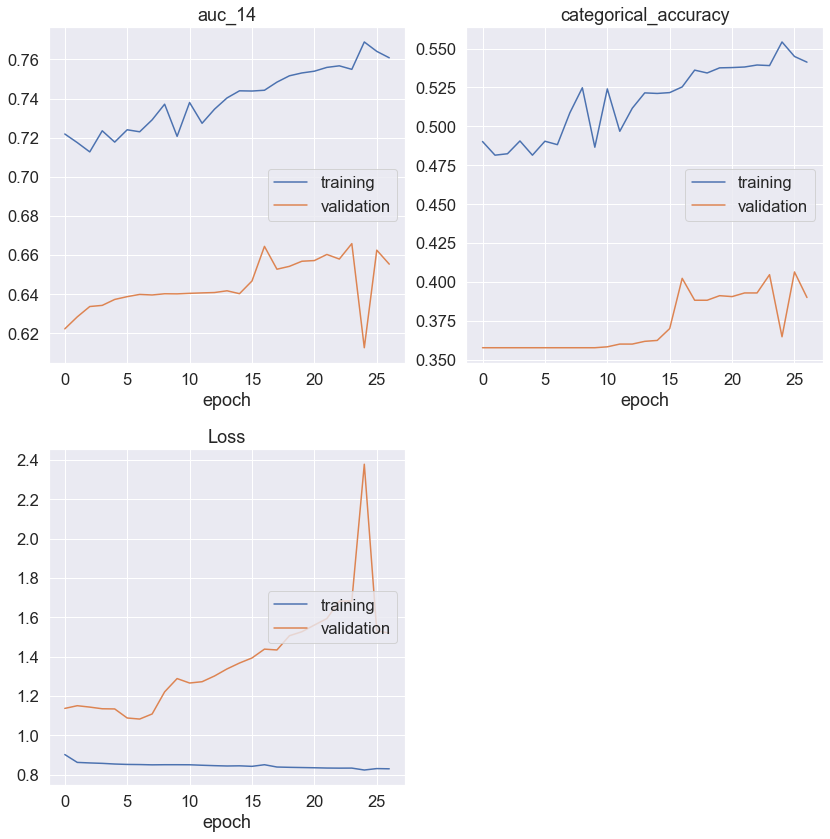

auc_14
	training         	 (min:    0.713, max:    0.769, cur:    0.761)
	validation       	 (min:    0.613, max:    0.666, cur:    0.655)
categorical_accuracy
	training         	 (min:    0.481, max:    0.554, cur:    0.541)
	validation       	 (min:    0.358, max:    0.406, cur:    0.390)
Loss
	training         	 (min:    0.823, max:    0.902, cur:    0.830)
	validation       	 (min:    1.083, max:    2.378, cur:    1.520)
5467/5467 [==============================] - 3s 615us/sample - loss: 0.8296 - categorical_accuracy: 0.5412 - auc_14: 0.7608 - val_loss: 1.5197 - val_categorical_accuracy: 0.3899 - val_auc_14: 0.6553
Training time:0:01:33.035801
1782/1782 [==============================] - 0s 167us/sample - loss: 0.8587 - categorical_accuracy: 0.4770 - auc_14: 0.7214
Accuracy on Test set: 47.70%
|biLSTM|
 Error rate = 0.5230078563411896 
 MSE =  0.654320987654321 
 Accuracy =  0.4769921436588103 
 AUC =  0.5721767997215547 
 F1-score =  0.2786177552228488 
 Fbeta =  0.33434776026466

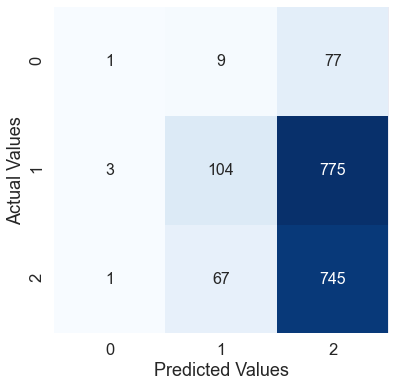

In [36]:
tic = datetime.now()

compile_train(biLSTM_model_all,X_train_all_scalled,Y_train_cat,X_val_all_scalled,Y_val_cat) 
time = datetime.now() - tic
print("Training time:{}".format(time))

scores = biLSTM_model_all.evaluate(X_test_all_scalled,Y_test_cat)
print("Accuracy on Test set: %.2f%%" % (scores[1]*100))

print(evaluate_error(biLSTM_model_all,X_test_all_scalled, Y_test_modif))

Selected features (non-scalled)

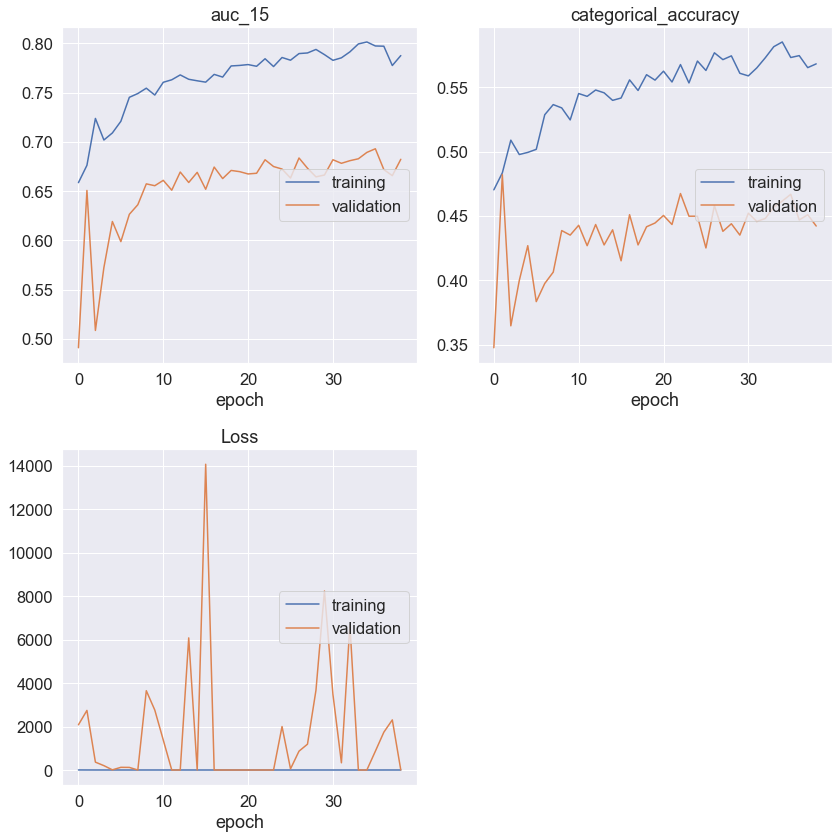

auc_15
	training         	 (min:    0.659, max:    0.801, cur:    0.787)
	validation       	 (min:    0.491, max:    0.693, cur:    0.682)
categorical_accuracy
	training         	 (min:    0.470, max:    0.585, cur:    0.568)
	validation       	 (min:    0.348, max:    0.482, cur:    0.442)
Loss
	training         	 (min:    0.765, max:    3.509, cur:    0.813)
	validation       	 (min:    1.036, max: 14066.840, cur:    1.130)
5467/5467 [==============================] - 3s 601us/sample - loss: 0.8127 - categorical_accuracy: 0.5681 - auc_15: 0.7875 - val_loss: 1.1305 - val_categorical_accuracy: 0.4422 - val_auc_15: 0.6823
Training time:0:02:08.703335
1782/1782 [==============================] - 0s 158us/sample - loss: 1.0598 - categorical_accuracy: 0.4804 - auc_15: 0.7170
Accuracy on Test set: 48.04%
|biLSTM|
 Error rate = 0.5196408529741863 
 MSE =  0.6189674523007856 
 Accuracy =  0.48035914702581367 
 AUC =  0.4946641526725786 
 F1-score =  0.33229539301733874 
 Fbeta =  0.3411187937

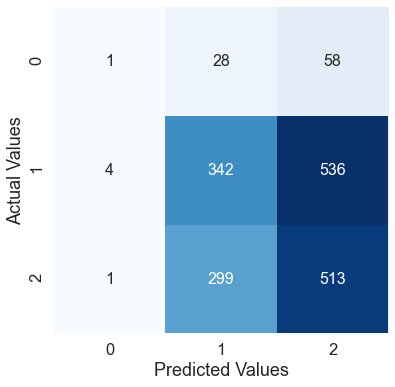

In [37]:
tic = datetime.now()

compile_train(biLSTM_model,X_train,Y_train_cat,X_val,Y_val_cat) 
time = datetime.now() - tic
print("Training time:{}".format(time))

scores = biLSTM_model.evaluate(X_test,Y_test_cat)
print("Accuracy on Test set: %.2f%%" % (scores[1]*100))

print(evaluate_error(biLSTM_model,X_test, Y_test_modif))

Selected features (scalled)

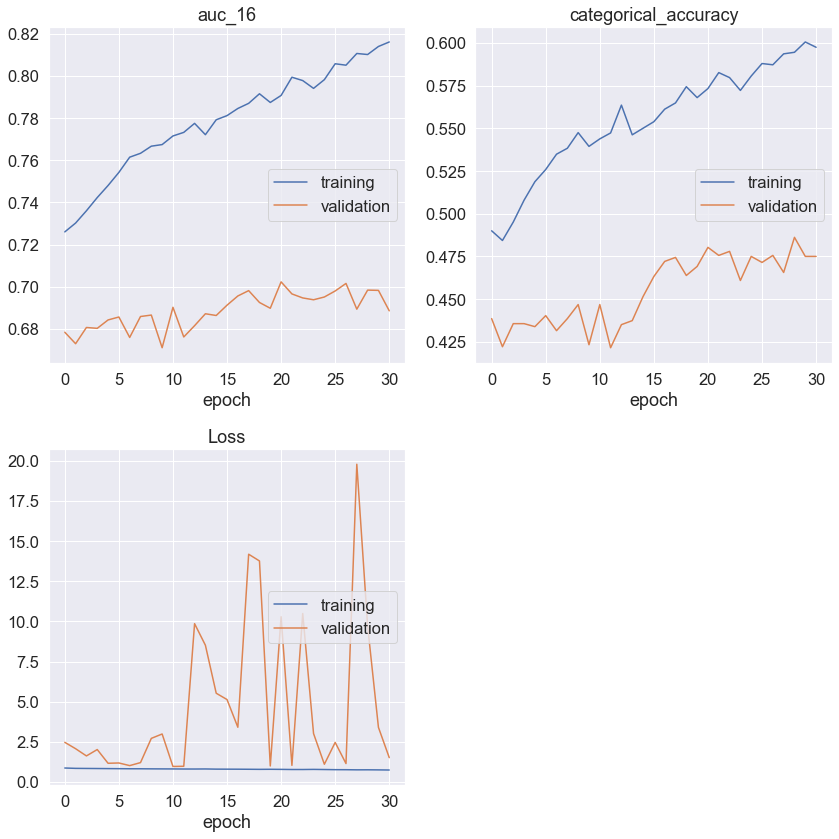

auc_16
	training         	 (min:    0.726, max:    0.816, cur:    0.816)
	validation       	 (min:    0.671, max:    0.702, cur:    0.689)
categorical_accuracy
	training         	 (min:    0.484, max:    0.601, cur:    0.597)
	validation       	 (min:    0.422, max:    0.486, cur:    0.475)
Loss
	training         	 (min:    0.745, max:    0.870, cur:    0.745)
	validation       	 (min:    0.965, max:   19.786, cur:    1.516)
5467/5467 [==============================] - 3s 607us/sample - loss: 0.7451 - categorical_accuracy: 0.5974 - auc_16: 0.8161 - val_loss: 1.5157 - val_categorical_accuracy: 0.4750 - val_auc_16: 0.6886
Training time:0:01:42.559969
1782/1782 [==============================] - 0s 165us/sample - loss: 1.2412 - categorical_accuracy: 0.4585 - auc_16: 0.6952
Accuracy on Test set: 45.85%
|biLSTM|
 Error rate = 0.5415263748597082 
 MSE =  0.6425364758698092 
 Accuracy =  0.45847362514029183 
 AUC =  0.49298153153867624 
 F1-score =  0.33570434416256517 
 Fbeta =  0.3356763463

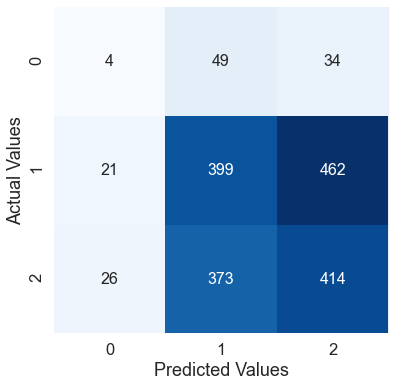

In [38]:
tic = datetime.now()

compile_train(biLSTM_model,X_train_scalled,Y_train_cat,X_val_scalled,Y_val_cat) 
time = datetime.now() - tic
print("Training time:{}".format(time))

scores = biLSTM_model.evaluate(X_test_scalled,Y_test_cat)
print("Accuracy on Test set: %.2f%%" % (scores[1]*100))
print(evaluate_error(biLSTM_model,X_test_scalled,Y_test_modif))

Eye Gaze only

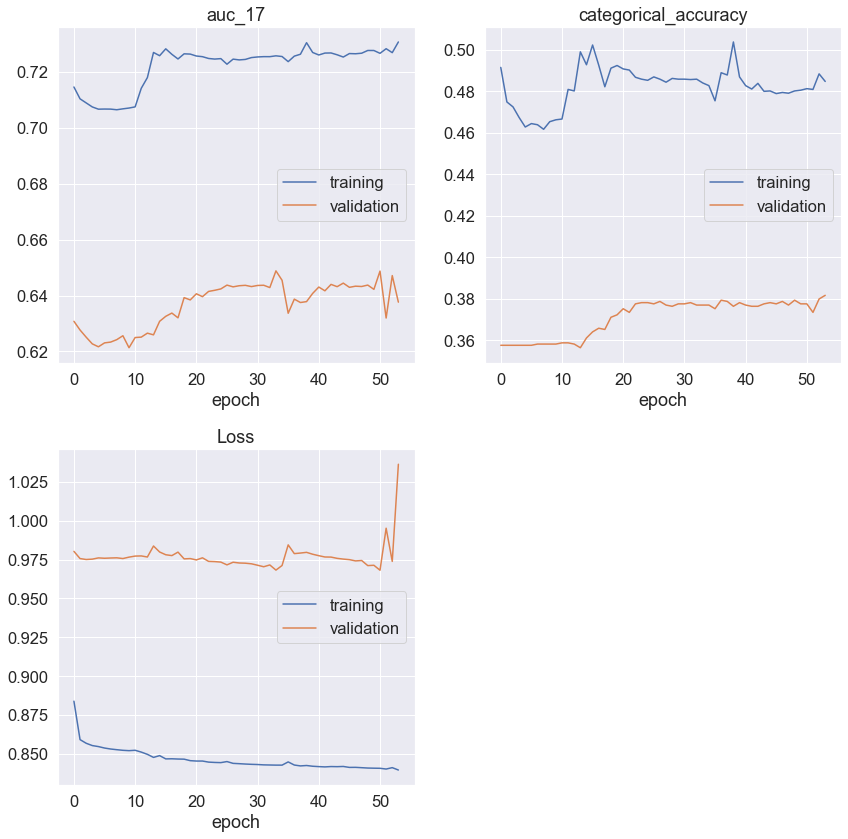

auc_17
	training         	 (min:    0.706, max:    0.731, cur:    0.731)
	validation       	 (min:    0.621, max:    0.649, cur:    0.638)
categorical_accuracy
	training         	 (min:    0.462, max:    0.504, cur:    0.485)
	validation       	 (min:    0.356, max:    0.382, cur:    0.382)
Loss
	training         	 (min:    0.840, max:    0.884, cur:    0.840)
	validation       	 (min:    0.968, max:    1.036, cur:    1.036)
5467/5467 [==============================] - 3s 597us/sample - loss: 0.8395 - categorical_accuracy: 0.4847 - auc_17: 0.7307 - val_loss: 1.0364 - val_categorical_accuracy: 0.3817 - val_auc_17: 0.6376
Training time:0:02:55.471995
1782/1782 [==============================] - 0s 162us/sample - loss: 0.8541 - categorical_accuracy: 0.4534 - auc_17: 0.7069
Accuracy on Test set: 45.34%
|biLSTM|
 Error rate = 0.5465768799102132 
 MSE =  0.6661054994388328 
 Accuracy =  0.45342312008978675 
 AUC =  0.5455247771214088 
 F1-score =  0.2725093371933022 
 Fbeta =  0.328287009773

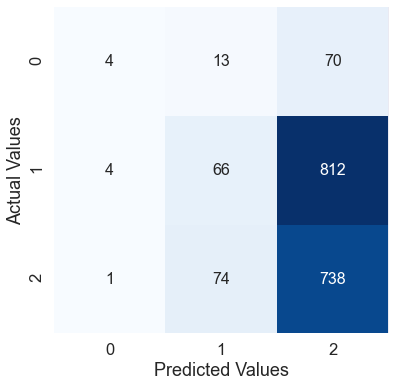

In [39]:
tic = datetime.now()

compile_train(biLSTM_model_feat,X_train_eye,Y_train_cat,X_val_eye,Y_val_cat) 
time = datetime.now() - tic
print("Training time:{}".format(time))

scores = biLSTM_model_feat.evaluate(X_test_eye,Y_test_cat)
print("Accuracy on Test set: %.2f%%" % (scores[1]*100))
print(evaluate_error(biLSTM_model_feat,X_test_eye,Y_test_modif))

Head Pose only

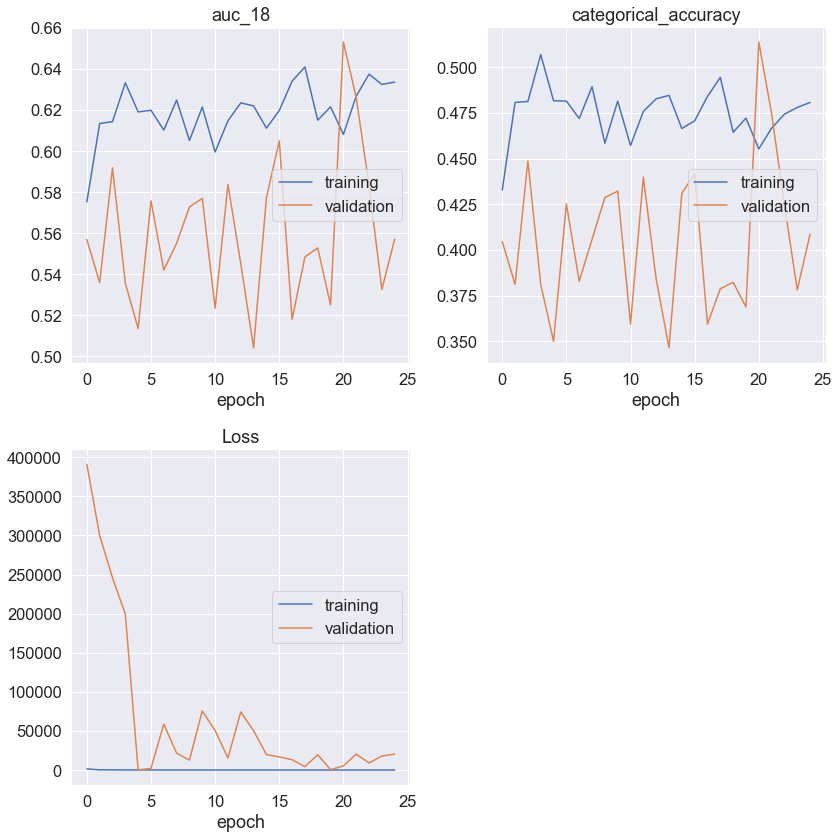

auc_18
	training         	 (min:    0.575, max:    0.641, cur:    0.634)
	validation       	 (min:    0.504, max:    0.653, cur:    0.557)
categorical_accuracy
	training         	 (min:    0.433, max:    0.507, cur:    0.481)
	validation       	 (min:    0.346, max:    0.514, cur:    0.409)
Loss
	training         	 (min:    9.110, max: 1401.010, cur:   11.500)
	validation       	 (min:  142.758, max: 391046.370, cur: 20331.071)
5467/5467 [==============================] - 3s 602us/sample - loss: 11.5000 - categorical_accuracy: 0.4807 - auc_18: 0.6336 - val_loss: 20331.0715 - val_categorical_accuracy: 0.4087 - val_auc_18: 0.5571
Training time:0:01:22.656874
1782/1782 [==============================] - 0s 162us/sample - loss: 9.4243 - categorical_accuracy: 0.4141 - auc_18: 0.5720
Accuracy on Test set: 41.41%
|biLSTM|
 Error rate = 0.5858585858585859 
 MSE =  0.8249158249158249 
 Accuracy =  0.41414141414141414 
 AUC =  0.48214508616528606 
 F1-score =  0.31876934277063146 
 Fbeta =  0.34

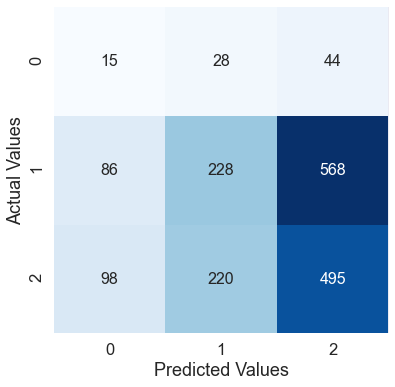

In [40]:
tic = datetime.now()

compile_train(biLSTM_model_feat,X_train_head,Y_train_cat,X_val_head,Y_val_cat) 
time = datetime.now() - tic
print("Training time:{}".format(time))

scores = biLSTM_model_feat.evaluate(X_test_head,Y_test_cat)
print("Accuracy on Test set: %.2f%%" % (scores[1]*100))
print(evaluate_error(biLSTM_model_feat,X_test_head,Y_test_modif))

AU only

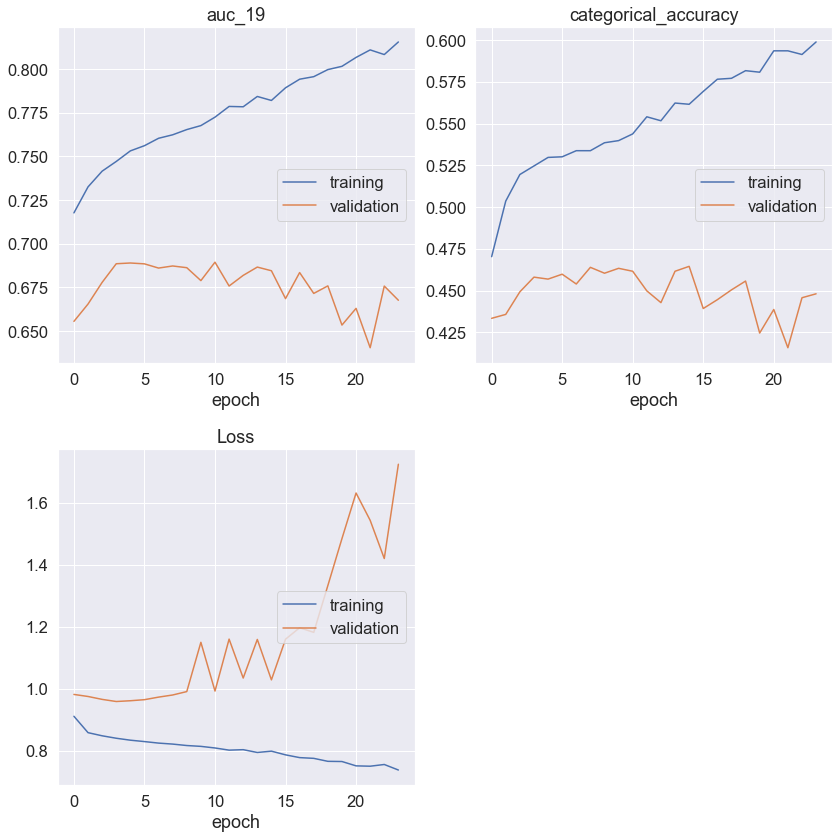

auc_19
	training         	 (min:    0.718, max:    0.815, cur:    0.815)
	validation       	 (min:    0.641, max:    0.689, cur:    0.668)
categorical_accuracy
	training         	 (min:    0.470, max:    0.599, cur:    0.599)
	validation       	 (min:    0.416, max:    0.464, cur:    0.448)
Loss
	training         	 (min:    0.738, max:    0.911, cur:    0.738)
	validation       	 (min:    0.959, max:    1.725, cur:    1.725)
5467/5467 [==============================] - 3s 592us/sample - loss: 0.7380 - categorical_accuracy: 0.5989 - auc_19: 0.8155 - val_loss: 1.7247 - val_categorical_accuracy: 0.4480 - val_auc_19: 0.6677
Training time:0:01:22.634089
1782/1782 [==============================] - 0s 158us/sample - loss: 1.1538 - categorical_accuracy: 0.4848 - auc_19: 0.7202
Accuracy on Test set: 48.48%
|biLSTM|
 Error rate = 0.5151515151515151 
 MSE =  0.601010101010101 
 Accuracy =  0.48484848484848486 
 AUC =  0.5443732074503024 
 F1-score =  0.3713477622308954 
 Fbeta =  0.3697060241095

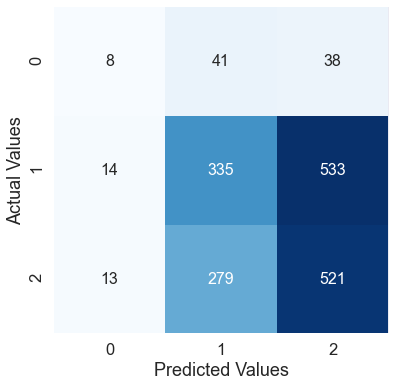

In [41]:
tic = datetime.now()

compile_train(biLSTM_model_au,X_train_au,Y_train_cat,X_val_au,Y_val_cat) 
time = datetime.now() - tic
print("Training time:{}".format(time))

scores = biLSTM_model_au.evaluate(X_test_au,Y_test_cat)
print("Accuracy on Test set: %.2f%%" % (scores[1]*100))
print(evaluate_error(biLSTM_model_au,X_test_au,Y_test_modif))

## 4. BiLSTM Ensamble

No feature selection  (329 dimensions)

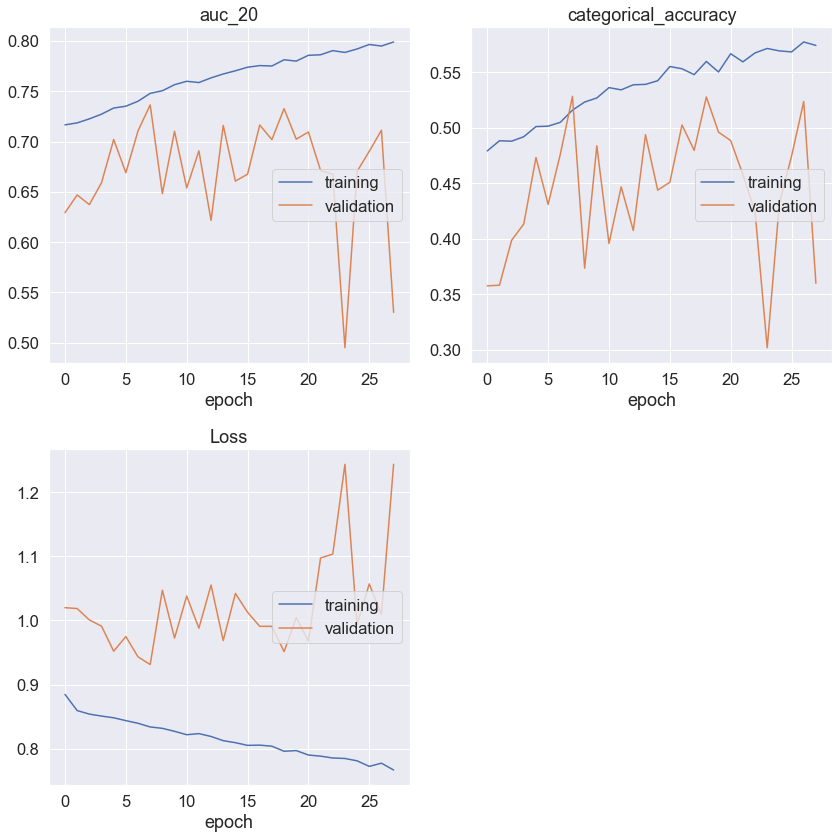

auc_20
	training         	 (min:    0.717, max:    0.799, cur:    0.799)
	validation       	 (min:    0.495, max:    0.736, cur:    0.530)
categorical_accuracy
	training         	 (min:    0.479, max:    0.577, cur:    0.574)
	validation       	 (min:    0.302, max:    0.528, cur:    0.360)
Loss
	training         	 (min:    0.767, max:    0.885, cur:    0.767)
	validation       	 (min:    0.931, max:    1.243, cur:    1.243)
5467/5467 [==============================] - 2s 300us/sample - loss: 0.7667 - categorical_accuracy: 0.5744 - auc_20: 0.7990 - val_loss: 1.2434 - val_categorical_accuracy: 0.3600 - val_auc_20: 0.5301
Training time:0:00:47.225972
1782/1782 [==============================] - 0s 104us/sample - loss: 1.2093 - categorical_accuracy: 0.2929 - auc_20: 0.4982
Accuracy on Test set: 29.29%
|biLSTM_en|
 Error rate = 0.7070707070707071 
 MSE =  1.2727272727272727 
 Accuracy =  0.29292929292929293 
 AUC =  0.5094840718283776 
 F1-score =  0.24662356546144978 
 Fbeta =  0.28532550

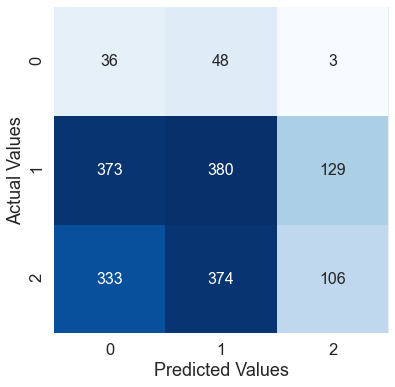

In [42]:
tic = datetime.now()

compile_train(biLSTM_en_model_all, X_train_all_scalled, Y_train_cat, X_val_all_scalled, Y_val_cat) 
time = datetime.now() - tic
print("Training time:{}".format(time))

scores = biLSTM_en_model_all.evaluate(X_test_all_scalled,Y_test_cat)
print("Accuracy on Test set: %.2f%%" % (scores[1]*100))
print(evaluate_error(biLSTM_en_model_all,X_test_all_scalled, Y_test_modif))

Selected features (scalled)

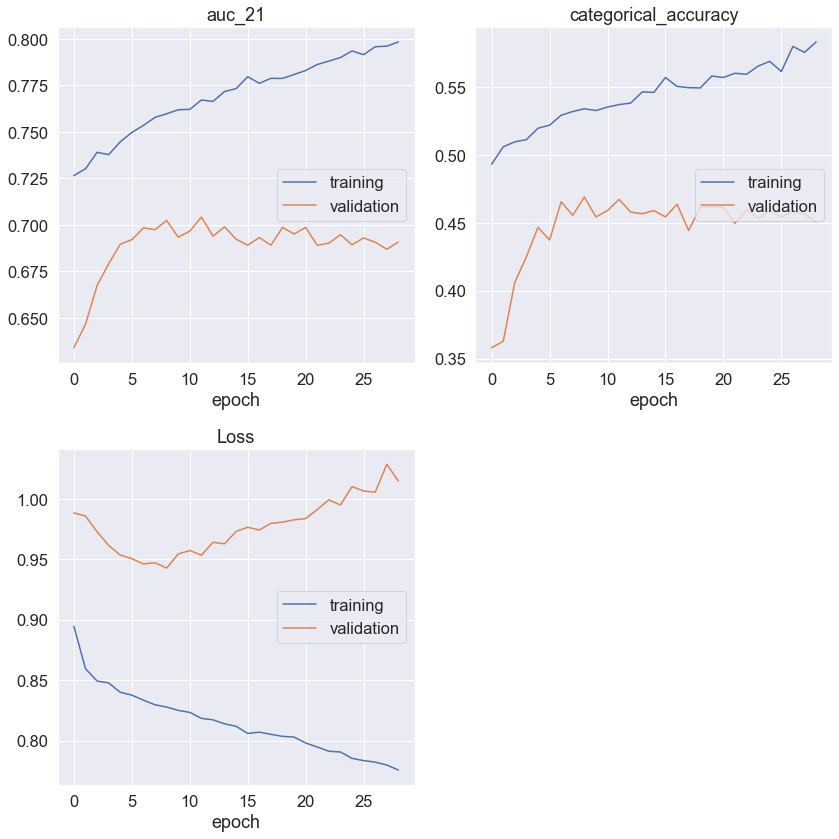

auc_21
	training         	 (min:    0.727, max:    0.798, cur:    0.798)
	validation       	 (min:    0.634, max:    0.704, cur:    0.691)
categorical_accuracy
	training         	 (min:    0.493, max:    0.583, cur:    0.583)
	validation       	 (min:    0.358, max:    0.469, cur:    0.451)
Loss
	training         	 (min:    0.776, max:    0.895, cur:    0.776)
	validation       	 (min:    0.943, max:    1.029, cur:    1.015)
5467/5467 [==============================] - 2s 294us/sample - loss: 0.7756 - categorical_accuracy: 0.5833 - auc_21: 0.7984 - val_loss: 1.0148 - val_categorical_accuracy: 0.4510 - val_auc_21: 0.6908
Training time:0:00:48.434865
1782/1782 [==============================] - 0s 95us/sample - loss: 0.9365 - categorical_accuracy: 0.4607 - auc_21: 0.7097
Accuracy on Test set: 46.07%
|biLSTM_en|
 Error rate = 0.5392817059483727 
 MSE =  0.6150392817059483 
 Accuracy =  0.4607182940516274 
 AUC =  0.5696465451796251 
 F1-score =  0.3251485577965734 
 Fbeta =  0.33490839437

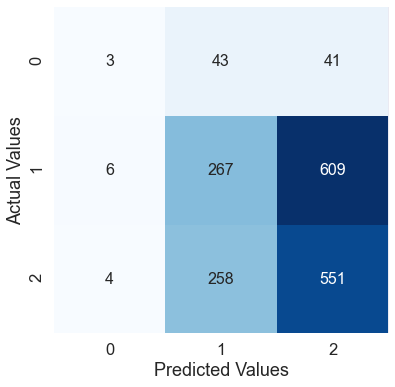

In [43]:
tic = datetime.now()

compile_train(biLSTM_en_model,X_train_scalled,Y_train_cat,X_val_scalled,Y_val_cat) 
time = datetime.now() - tic
print("Training time:{}".format(time))

scores = biLSTM_en_model.evaluate(X_test_scalled,Y_test_cat)
print("Accuracy on Test set: %.2f%%" % (scores[1]*100))
print(evaluate_error(biLSTM_en_model,X_test_scalled,Y_test_modif))

Selected features (non-scalled)

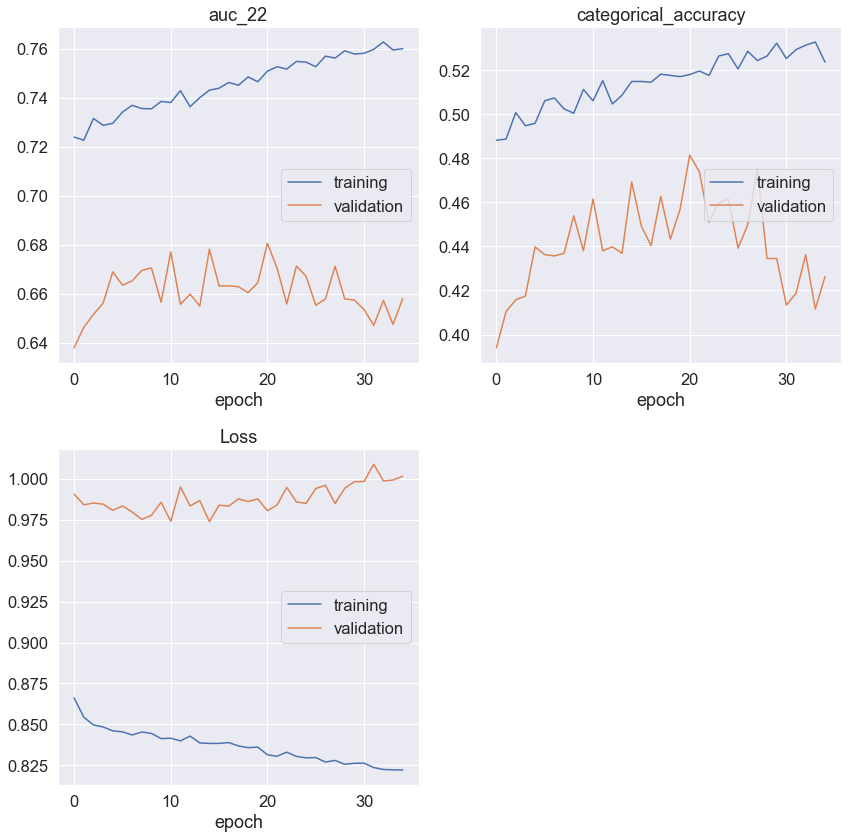

auc_22
	training         	 (min:    0.723, max:    0.763, cur:    0.760)
	validation       	 (min:    0.638, max:    0.681, cur:    0.658)
categorical_accuracy
	training         	 (min:    0.488, max:    0.533, cur:    0.524)
	validation       	 (min:    0.394, max:    0.482, cur:    0.426)
Loss
	training         	 (min:    0.822, max:    0.866, cur:    0.822)
	validation       	 (min:    0.974, max:    1.009, cur:    1.002)
5467/5467 [==============================] - 2s 286us/sample - loss: 0.8222 - categorical_accuracy: 0.5237 - auc_22: 0.7600 - val_loss: 1.0015 - val_categorical_accuracy: 0.4263 - val_auc_22: 0.6581
Training time:0:00:57.631093
1782/1782 [==============================] - 0s 105us/sample - loss: 0.8672 - categorical_accuracy: 0.4770 - auc_22: 0.7169
Accuracy on Test set: 47.70%
|biLSTM_en|
 Error rate = 0.5230078563411896 
 MSE =  0.5953984287317621 
 Accuracy =  0.4769921436588103 
 AUC =  0.5293540769655388 
 F1-score =  0.31998979339708195 
 Fbeta =  0.335239448

c:\Users\hasegawa-lab-pc\miniconda3\envs\tf2.1\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


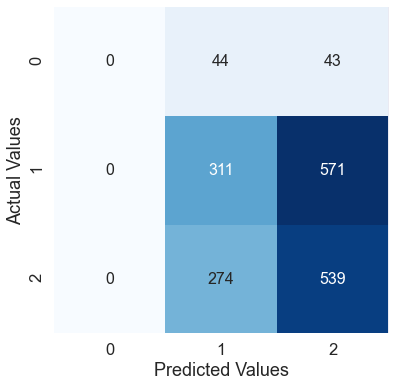

In [44]:
tic = datetime.now()

compile_train(biLSTM_en_model,X_train,Y_train_cat,X_val,Y_val_cat) 
time = datetime.now() - tic
print("Training time:{}".format(time))

scores = biLSTM_en_model.evaluate(X_test,Y_test_cat)
print("Accuracy on Test set: %.2f%%" % (scores[1]*100))

print(evaluate_error(biLSTM_en_model,X_test, Y_test_modif))

Eye Gaze only

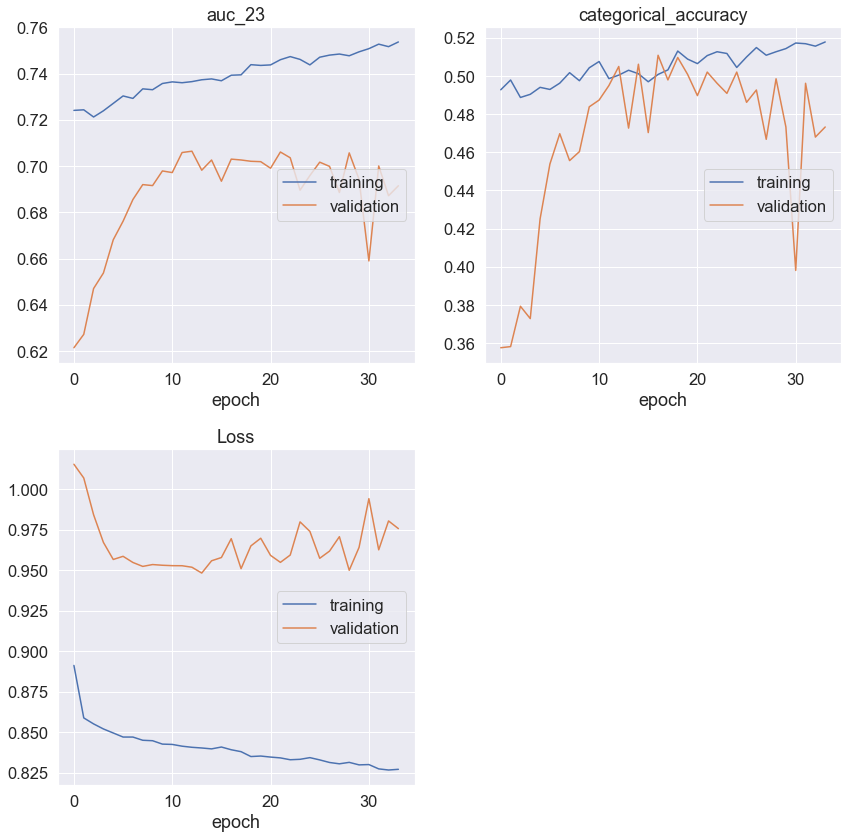

auc_23
	training         	 (min:    0.721, max:    0.754, cur:    0.754)
	validation       	 (min:    0.621, max:    0.706, cur:    0.692)
categorical_accuracy
	training         	 (min:    0.489, max:    0.518, cur:    0.518)
	validation       	 (min:    0.358, max:    0.511, cur:    0.473)
Loss
	training         	 (min:    0.827, max:    0.891, cur:    0.827)
	validation       	 (min:    0.948, max:    1.015, cur:    0.976)
5467/5467 [==============================] - 2s 290us/sample - loss: 0.8271 - categorical_accuracy: 0.5178 - auc_23: 0.7537 - val_loss: 0.9757 - val_categorical_accuracy: 0.4733 - val_auc_23: 0.6915
Training time:0:00:56.801316
1782/1782 [==============================] - 0s 102us/sample - loss: 0.9153 - categorical_accuracy: 0.4820 - auc_23: 0.7140
Accuracy on Test set: 48.20%
|biLSTM_en|
 Error rate = 0.5179573512906847 
 MSE =  0.5482603815937149 
 Accuracy =  0.4820426487093154 
 AUC =  0.5246358030630894 
 F1-score =  0.3294816445977624 
 Fbeta =  0.3370218951

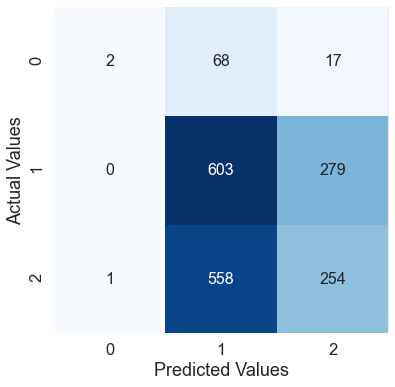

In [45]:
tic = datetime.now()

compile_train(biLSTM_en_model_feat,X_train_eye,Y_train_cat,X_val_eye,Y_val_cat) 
time = datetime.now() - tic
print("Training time:{}".format(time))

scores = biLSTM_en_model_feat.evaluate(X_test_eye,Y_test_cat)
print("Accuracy on Test set: %.2f%%" % (scores[1]*100))
print(evaluate_error(biLSTM_en_model_feat,X_test_eye,Y_test_modif))

Head Pose only

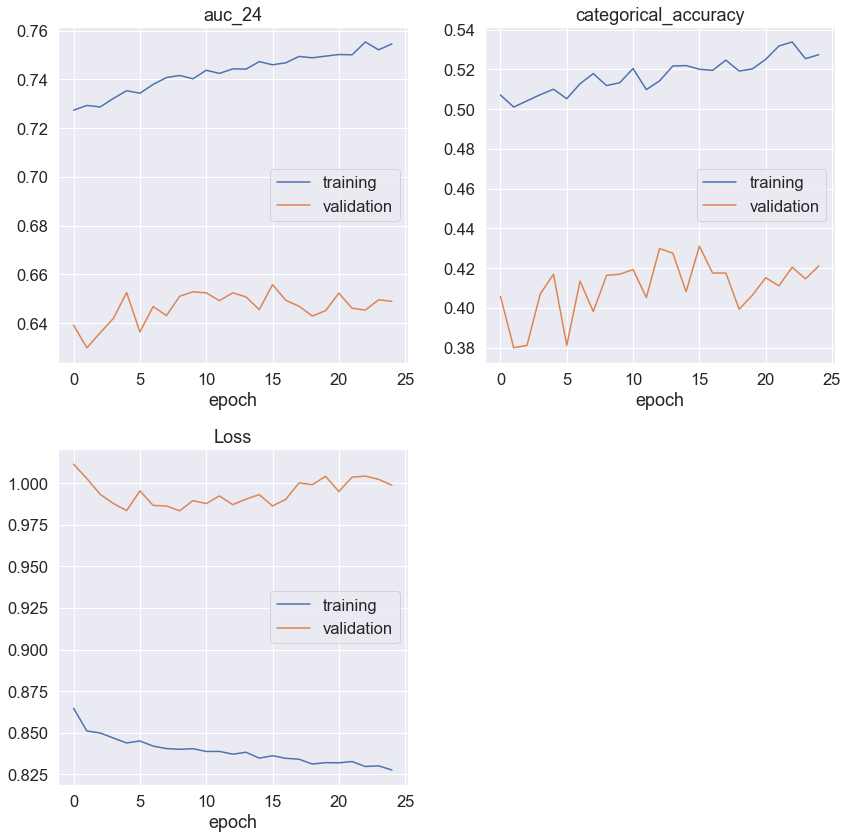

auc_24
	training         	 (min:    0.727, max:    0.755, cur:    0.755)
	validation       	 (min:    0.630, max:    0.656, cur:    0.649)
categorical_accuracy
	training         	 (min:    0.501, max:    0.534, cur:    0.527)
	validation       	 (min:    0.380, max:    0.431, cur:    0.421)
Loss
	training         	 (min:    0.828, max:    0.865, cur:    0.828)
	validation       	 (min:    0.983, max:    1.011, cur:    0.999)
5467/5467 [==============================] - 2s 281us/sample - loss: 0.8277 - categorical_accuracy: 0.5273 - auc_24: 0.7545 - val_loss: 0.9987 - val_categorical_accuracy: 0.4210 - val_auc_24: 0.6490
Training time:0:00:41.211131
1782/1782 [==============================] - 0s 99us/sample - loss: 0.8609 - categorical_accuracy: 0.4804 - auc_24: 0.7163
Accuracy on Test set: 48.04%
|biLSTM_en|
 Error rate = 0.5196408529741863 
 MSE =  0.6038159371492705 
 Accuracy =  0.48035914702581367 
 AUC =  0.5404037291531061 
 F1-score =  0.31726887299302564 
 Fbeta =  0.337426226

c:\Users\hasegawa-lab-pc\miniconda3\envs\tf2.1\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


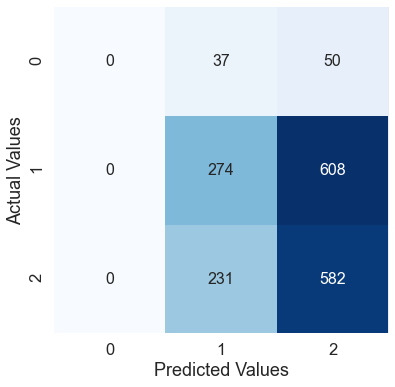

In [46]:
tic = datetime.now()

compile_train(biLSTM_en_model_feat,X_train_head,Y_train_cat,X_val_head,Y_val_cat) 
time = datetime.now() - tic
print("Training time:{}".format(time))

scores = biLSTM_en_model_feat.evaluate(X_test_head,Y_test_cat)
print("Accuracy on Test set: %.2f%%" % (scores[1]*100))
print(evaluate_error(biLSTM_en_model_feat,X_test_head,Y_test_modif))

AU only

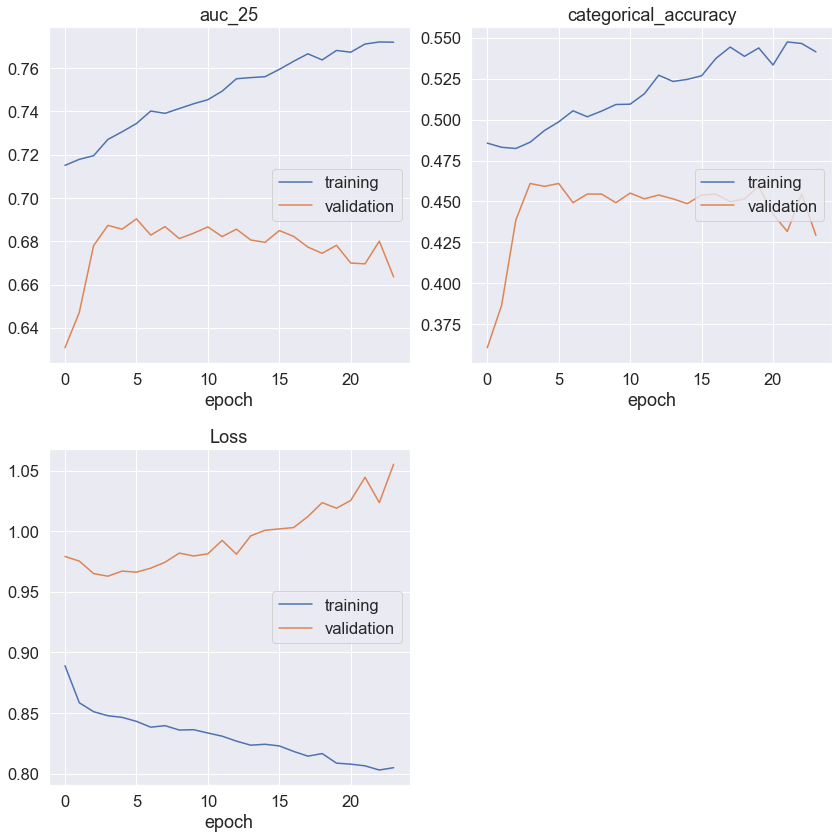

auc_25
	training         	 (min:    0.715, max:    0.772, cur:    0.772)
	validation       	 (min:    0.631, max:    0.690, cur:    0.664)
categorical_accuracy
	training         	 (min:    0.482, max:    0.547, cur:    0.541)
	validation       	 (min:    0.361, max:    0.461, cur:    0.429)
Loss
	training         	 (min:    0.803, max:    0.889, cur:    0.805)
	validation       	 (min:    0.963, max:    1.055, cur:    1.055)
5467/5467 [==============================] - 2s 281us/sample - loss: 0.8049 - categorical_accuracy: 0.5414 - auc_25: 0.7720 - val_loss: 1.0554 - val_categorical_accuracy: 0.4292 - val_auc_25: 0.6636
Training time:0:00:39.486914
1782/1782 [==============================] - 0s 95us/sample - loss: 0.8889 - categorical_accuracy: 0.4905 - auc_25: 0.7285
Accuracy on Test set: 49.05%
|biLSTM_en|
 Error rate = 0.5095398428731762 
 MSE =  0.5953984287317621 
 Accuracy =  0.4904601571268238 
 AUC =  0.5680908045432814 
 F1-score =  0.35471391478968634 
 Fbeta =  0.3593654484

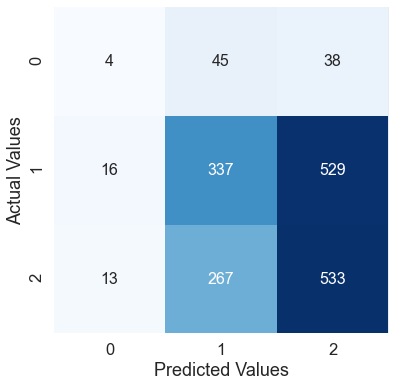

In [47]:
tic = datetime.now()

compile_train(biLSTM_en_model_au,X_train_au,Y_train_cat,X_val_au,Y_val_cat) 
time = datetime.now() - tic
print("Training time:{}".format(time))

scores = biLSTM_en_model_au.evaluate(X_test_au,Y_test_cat)
print("Accuracy on Test set: %.2f%%" % (scores[1]*100))
print(evaluate_error(biLSTM_en_model_au,X_test_au,Y_test_modif))